# Study of the dipoles directions

This code creates the tools that will be useful to fit dipoles and study their directions.
What this code does:

- it creates the function allowing to retreive the coordinates of the dipole from the vector characterising it
- it creates some CMB maps, compute their local power spectra and fit a dipole for each reconstructed map (for each bin)
- then, it analyses the results in term of map showing the dipoles' directions for all the map, with the histograms in cos$\theta$ and $\phi$ as well as with the mean separation angle $\theta_{mean}$

In [4]:
import healpy as hp
from astrotools import healpytools as hpt
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import time
import pymaster as nmt
from scipy.stats import binned_statistic
from numpy import loadtxt
import csv

import warnings
warnings.filterwarnings("ignore")

In [41]:
masks_sharp = []
masks_Sm = []
masks_C1 = []
masks_C2 = []

for i in range(12):
    masks_sharp.append(hp.read_map('Mask%s_sharp'%i))
    masks_Sm.append(hp.read_map('./Masks/Mask%s_apoSm'%i))
    masks_C1.append(hp.read_map('./Masks/Mask%s_apoC1'%i))
    masks_C2.append(hp.read_map('./Masks/Mask%s_apoC2'%i))

smooth_masks = masks_Sm
C1_apod_masks = masks_C1
C2_apod_masks = masks_C2

In [42]:
PLA_best_PS = pd.read_csv("COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01_copie.txt", delim_whitespace=True, index_col=0) # taking the PLA power spectrum

max_size = False
if max_size : # high value of Nside
    nside = 1024
    lmax = PLA_best_PS.index[-1]
else :        # low value of Nside
    nside = 512
    lmax = 2 * nside - 1
    #lmax = 3 * nside - 1

cl = PLA_best_PS.divide(PLA_best_PS.index * (PLA_best_PS.index+1) / (2*np.pi), axis="index")
cl /= 1e12 # in muK^2
cl = cl.reindex(np.arange(0, lmax+1)) # re index because it begins at 2
cl = cl.fillna(0) # replace the 1st values by 0 instead of NaN

seed = 583
np.random.seed(seed)

fwhm = 20 * np.pi / (60*180) # 20 arcmin in rad

In [43]:
PLA_PS = np.loadtxt("COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")

# binning
bin_size = 16
number_of_bins = int(lmax/bin_size)  # each bin contains bin_size values of l
ell = np.arange(lmax+1)
ell_edge = [2.+i*bin_size for i in range(number_of_bins+1)]

bin_PLA_PS = binned_statistic(ell, PLA_PS.T[:,:lmax+1], statistic='mean', bins=ell_edge)

fwhm = 20 * np.pi / (60*180) # 20 arcmin in rad
sigma = fwhm/2.35

Cl_beam = np.exp(- ell*(ell+1) * sigma**2)
Bl_pixwin = hp.sphtfunc.pixwin(nside, pol=True, lmax=lmax)
Cl_pixwin = [Bl_pixwin[i]**2 for i in range(len(Bl_pixwin))] # Cl = Bl^2

bin_PLA_PS = binned_statistic(ell, PLA_PS.T[:,:lmax+1], statistic='mean', bins=ell_edge)
Cl_beam_bin = binned_statistic(ell, Cl_beam, statistic='mean', bins=ell_edge)
Cl_pixwin_bin = binned_statistic(ell, Cl_pixwin, statistic='mean', bins=ell_edge)

### Dipole direction and amplitude: test: add, fit and remove a dipole from a CMB map

vec_max [-6.28280811e-17 -3.42020143e-01  9.39692621e-01]
map: [ 4.37124531e-05  8.43012628e-06  6.08278636e-05 ... -1.36041083e-04
 -1.24012319e-04 -1.01288458e-04]
monopole: 2.883948514446001e-12
dipole vector: [ 1.52278799e-12 -1.12866648e-03  3.10098559e-03]

lat: 69.99999954406336 degrees
lon: 270.000000077303 degrees

amplitude: 3.299999942089086 mK
(69.99999954406336, 270.000000077303, 0.003299999942089086)


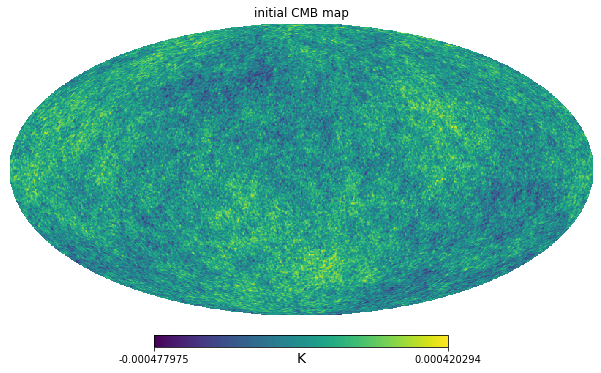

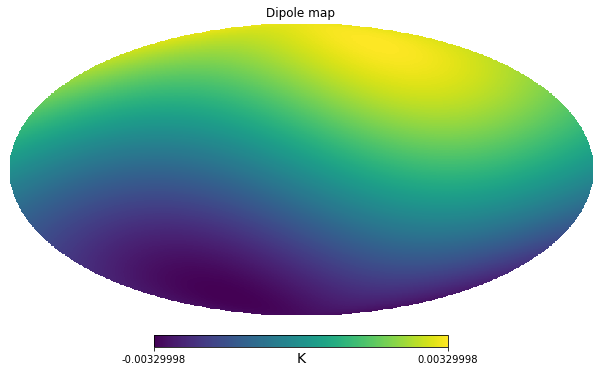

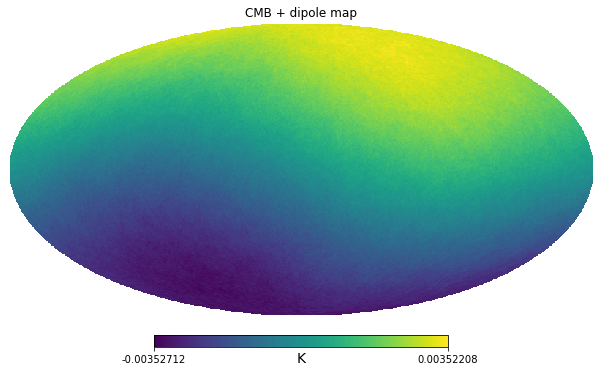

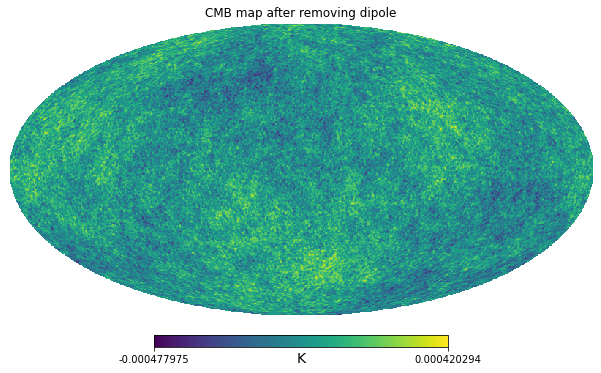

In [60]:
CMB_alm = hp.synalm((cl.TT, cl.EE, cl.BB, cl.TE), lmax=lmax, new=True)
CMB_map = hp.alm2map(CMB_alm, nside=nside, lmax=lmax, pixwin=True, fwhm=fwhm)
hp.mollview(CMB_map[0], title='initial CMB map', unit='K')

npix = CMB_map[0].shape[-1]
npix = hpt.nside2npix(nside)
lat, lon = 70, 270     # Position of the maximum of the dipole, lat and lon in degrees, with convention 0° at the center
rlat, rlon = np.radians(lat), np.radians(lon)           # Colatitude and longitude in radian
vec_max = hp.ang2vec(np.pi/2-rlat, rlon)                # Convert this to a vector with colatitude in [0,pi]
print('vec_max', vec_max)
amplitude = 3.3*1e-3                                              # Amplitude of the dipole
dipole_map = hpt.dipole_pdf(nside, amplitude, vec_max, pdf=False) # Creation of the dipole map
dipole_map = dipole_map - 1                                       # Amplitude of the dipole map centered on 0
hp.mollview(dipole_map, title='Dipole map', unit='K')
# Convention for the plot of the dipole map:
# lat in [0°(north),180°(south)] and lon in [0°(center),360°] (180° east/west)

CMB_dipole_map = CMB_map[0] + dipole_map
hp.mollview(CMB_dipole_map, title='CMB + dipole map', unit='K')

rm_dipole = hp.remove_dipole(CMB_dipole_map, nest=False, fitval=True, copy=True) 
print('map:', rm_dipole[0])
print('monopole:', rm_dipole[1])
print('dipole vector:', rm_dipole[2])

hp.mollview(rm_dipole[0], title='CMB map after removing dipole', unit='K')

# Latitude, longitude and amplitude values
lat = np.arctan(rm_dipole[2][2]/np.sqrt(rm_dipole[2][0]**2+rm_dipole[2][1]**2))
lat = np.degrees(lat)
#if np.degrees(rlat) > 90: # if convention : colatitude in [0,pi] and not in [-pi,pi]
#    lat = np.fabs(lat-180)
print('\nlat:',lat,'degrees')

lon1 = np.arctan(rm_dipole[2][1]/rm_dipole[2][0])
lon = np.degrees(lon1)

if rm_dipole[2][0]<0:
    lon = lon + 180 # to recover the longitude with the convention where 0° is at the center of the map
if lon < 0:
    lon = lon+360
print('lon:',lon,'degrees')

amplitude = np.linalg.norm([rm_dipole[2][0],rm_dipole[2][1],rm_dipole[2][2]])
print('\namplitude:', amplitude*1e3, 'mK')

In [6]:
def retrieve_angles(dip_vector):
    """ From a vector of 3 elements, this code can retrieve:
    - the coordinates of the dipole direction theta (latitude) and phi (longitude) in degrees
      with the convention 0° at the center of the map
    - the amplitude of the dipole in K
    """
    
    rlat = np.arctan(dip_vector[2]/np.sqrt(dip_vector[0]**2+dip_vector[1]**2))
    lat = np.degrees(rlat)
    #print('\nlat:',lat,'degrees')

    rlon = np.arctan(dip_vector[1]/dip_vector[0])
    lon = np.degrees(rlon)
    if dip_vector[0]<0:
        lon = lon + 180 # to recover the longitude with the convention where 0° is at the center of the map
    if lon < 0:
        lon = lon+360
    #print('lon:',lon,'degrees')

    amplitude = np.linalg.norm([dip_vector[0],dip_vector[1],dip_vector[2]])
    #print('amplitude:', amplitude*1e3, 'mK')
    
    return lat,lon,amplitude

### Binned power spectra for each one of the 12 patches, with C1 apodisation

In [ ]:
number_of_maps = 1 # number of maps that we want to average (at maximum)
CMB_maps = [] # list of the maps
Cls_C1 = [] # np.shape() = (number_of_maps, 12(number of patches), 3(TT,TE,EE), number_of_bins)
Dls_C1 = []

delta_Cl_list = []
delta_average_list = []

y_average_PS_C1 = [] # list of the averaged power spectra for 1,2,... maps (np.shape=(number_of_maps,6,lmax))
y_subtraction = [] # list of the difference between the averaged PS and the Planck PS (np.shape=(number_of_maps,3,lmax))


start_time = time.time()

for i in range(number_of_maps):
    Cls_C1_patches = []
    Dls_C1_patches = []
    y_average_patches = []

    for k in range(len(masks_C1)):
   
        # creation of the maps
        alm = hp.synalm((cl.TT, cl.EE, cl.BB, cl.TE), lmax=lmax, new=True)
        CMB_map = hp.alm2map(alm, nside=nside, lmax=lmax, pixwin=True, fwhm=fwhm) # returns a list of T,Q,U maps
        CMB_maps.append(CMB_map) # optionnal

        # Read healpix maps and initialize a spin-0 and spin-2 field
        f_0_C1 = nmt.NmtField(masks_C1[k], [CMB_map[0]])
        f_2_C1 = nmt.NmtField(masks_C1[k], [CMB_map[1],CMB_map[2]])

        # Initialize binning scheme with 'bin_size' ells per bandpower
        b = nmt.NmtBin.from_nside_linear(nside, bin_size)

        # Compute MASTER estimator
        cl_00_C1 = nmt.compute_full_master(f_0_C1, f_0_C1, b)
        cl_02_C1 = nmt.compute_full_master(f_0_C1, f_2_C1, b)
        cl_22_C1 = nmt.compute_full_master(f_2_C1, f_2_C1, b)

        cl_00_C1 = cl_00_C1[0][:number_of_bins]
        cl_02_C1 = cl_02_C1[0][:number_of_bins]
        cl_22_C1 = cl_22_C1[0][:number_of_bins]

        ell_arr = b.get_effective_ells()
        ell_arr = ell_arr[:number_of_bins]

        # correction for beam and pixel window function
        cl_C1 = []
        cl_00_C1 /= (Cl_beam_bin[0] * Cl_pixwin_bin[0][0]) # no need to divide by f_sky because the map and mask weren't multiplied
        cl_C1.append(cl_00_C1)
        cl_02_C1 /= (Cl_beam_bin[0] * Cl_pixwin_bin[0][0])
        cl_C1.append(cl_02_C1)
        cl_22_C1 /= (Cl_beam_bin[0] * Cl_pixwin_bin[0][0])
        cl_C1.append(cl_22_C1)
        Cls_C1_patches.append(cl_C1)

        # Compute the Dls
        dl_C1 = []
        dl_00_C1 = cl_00_C1 * ell_arr * (ell_arr+1) * 1e12 / (2*np.pi)
        dl_C1.append(dl_00_C1)
        dl_02_C1 = cl_02_C1 * ell_arr * (ell_arr+1) * 1e12 / (2*np.pi)
        dl_C1.append(dl_02_C1)
        dl_22_C1 = cl_22_C1 * ell_arr * (ell_arr+1) * 1e12 / (2*np.pi)
        dl_C1.append(dl_22_C1)
        Dls_C1_patches.append(dl_C1)

        # variance
        #delta_Cl = []
        #for j in range(len(Dl)):
        #    delta = [math.sqrt(2/(2*l+1))*Dl[j][l] for l in range(len(Dl[j]))]
        #    delta_Cl.append(delta)
        #delta_Cl_list.append(delta_Cl)

        # average power spectra of the maps    
        y_average_C1 = []
        Cl_00_average_C1 = 0
        for j in range(len(Dls_C1_patches)):
            Cl_00_average_C1 += np.array(Dls_C1_patches[j][0])
        Cl_00_average_C1 = Cl_00_average_C1/(i+1)
        Cl_00_average_C1 = list(Cl_00_average_C1) # np.shape(Cl_average) = (6, lmax)
        y_average_C1.append(Cl_00_average_C1)

        Cl_02_average_C1 = 0
        for j in range(len(Dls_C1_patches)):
            Cl_02_average_C1 += np.array(Dls_C1_patches[j][1])
        Cl_02_average_C1 = Cl_02_average_C1/(i+1)
        Cl_02_average_C1 = list(Cl_02_average_C1) # np.shape(Cl_average) = (6, lmax)
        y_average_C1.append(Cl_02_average_C1)

        Cl_22_average_C1 = 0
        for j in range(len(Dls_C1_patches)):
            Cl_22_average_C1 += np.array(Dls_C1_patches[j][2])
        Cl_22_average_C1 = Cl_22_average_C1/(i+1)
        Cl_22_average_C1 = list(Cl_22_average_C1) # np.shape(Cl_average) = (6, lmax)
        y_average_C1.append(Cl_22_average_C1)

        y_average_patches.append(y_average_C1)

        # average of the variances (optionnal)
        #delta_average = 0
        #for j in range(len(delta_Cl_list)):
        #    delta_average += np.array(delta_Cl_list[j])
        #delta_average = delta_average/(i+1)
        #delta_average = list(delta_average)
        #delta_average_list.append(delta_average)

        #bin_means = binned_statistic(ell, Cl_average, statistic='mean', bins=number_of_bins)
        #bin_means_list.append(bin_means)

        # subtraction of Cl_average and Planck PS
        # PLA_best_PS = l, TT, TE, EE, BB, PP
        # Cl = TT, EE, BB, TE, EB, TB
        #y_total = []
        #y_TT = list(abs(np.array(Cl_average[0][:])-np.array(PLA_best_PS.T[1,:lmax+1])))
        #y_EE = list(abs(np.array(Cl_average[1][:])-np.array(PLA_best_PS.T[3,:lmax+1])))
        #y_TE = list(abs(np.array(Cl_average[3][:])-np.array(PLA_best_PS.T[2,:lmax+1])))
        #y_total.append(y_TT)
        #y_total.append(y_EE)
        #y_total.append(y_TE)
        #y_subtraction.append(y_total) # np.shape = (number_of_maps,3,lmax)    

    Cls_C1.append(Cls_C1_patches)
    Dls_C1.append(Dls_C1_patches)
    y_average_PS_C1.append(y_average_patches)
    
print((time.time() - start_time)/60, "min")

In [ ]:
List = [] # np.shape = (number_of_maps, number_of_bins, 3(TT,EE,TE), 12(patches))
# List contains all the Cls for the different maps, bins, temperature and polarisation, for the 12 patches
for maps in range(number_of_maps):
    bin_i = []
    for i in range(number_of_bins):
        TT_TE_EE = []
        for temp_pol in range(3):
            values = []
            for pixel in range(12):  
                value = Dls_C1[maps][pixel][temp_pol][i]
                values.append(value)
            TT_TE_EE.append(values)
        bin_i.append(TT_TE_EE)
    List.append(bin_i)
np.shape(List)

In [6]:
def ring2nest_map(map):
    """ This code transforms a map in ring format into a map in nest format. """
    nested_map = np.zeros(len(map))    # Creation of a new map of zeros
    Nside = hp.npix2nside(len(map))
    new_place = hp.pixelfunc.ring2nest(Nside, np.arange(len(map))) # we calculate the new position of the pixels for the nested format
    for j in range(len(new_place)):
        nested_map[j] = map[new_place[j]] # and add the values of the mask for the new format.
    #hp.mollview(nested_map, title='map with dipole')
    return nested_map

def nest2ring_map(map):
    """ This code transforms a map in nest format into a map in ring format. """
    ring_map = np.zeros(len(map))    # Creation of a new map of zeros
    Nside = hp.npix2nside(len(map))
    new_place = hp.pixelfunc.nest2ring(Nside, np.arange(len(map))) # we calculate the new position of the pixels for the nested format
    for j in range(len(new_place)):
        ring_map[j] = map[new_place[j]] # and add the values of the mask for the new format.
    #hp.mollview(nested_map, title='map with dipole')
    return ring_map

#### For each bin, creation of a new map from the patches, then fit a dipole of these new maps:

In [ ]:
# nside = 512
nb_pix = hp.nside2npix(nside)

# Creation of new maps from the patches, for the different bins
bin_maps = [] # np.shape = (number_of_maps, 63 (number_of_bins,) 3 (TT,EE,TE), number_of_pixels)

for nb_maps in range(number_of_maps):

    bin_maps_1 = [] # np.shape = (63 (number_of_bins,) 3 (TT,EE,TE), number_of_pixels)
    
    for k in range(number_of_bins):
        bin_map_TT = np.zeros(nb_pix)
        for j in range(12):                                        # For the 12 patches of the sky,
            for i in range(j*int(nb_pix/12),(j+1)*int(nb_pix/12)): # select the place where there will be the mask,
                bin_map_TT[i] = List[nb_maps][k][0][j]                   # then add the value 1 where there is the mask.

        bin_map_EE = np.zeros(nb_pix)
        for j in range(12):                                        # For the 12 patches of the sky,
            for i in range(j*int(nb_pix/12),(j+1)*int(nb_pix/12)): # select the place where there will be the mask,
                bin_map_EE[i] = List[nb_maps][k][1][j]                   # then add the value 1 where there is the mask.

        bin_map_TE = np.zeros(nb_pix)
        for j in range(12):                                        # For the 12 patches of the sky,
            for i in range(j*int(nb_pix/12),(j+1)*int(nb_pix/12)): # select the place where there will be the mask,
                bin_map_TE[i] = List[nb_maps][k][2][j]                   # then add the value 1 where there is the mask.

        nested_TT = ring2nest_map(bin_map_TT)
        nested_EE = ring2nest_map(bin_map_EE)
        nested_TE = ring2nest_map(bin_map_TE)
        nested_bin_map = [nested_TT, nested_EE, nested_TE]

        bin_maps_1.append(nested_bin_map)
        
    bin_maps.append(bin_maps_1)

# Remove the dipoles of these new maps 
rm_dipoles = [] # np.shape = (number_of_maps, 63(number_of_bins), 3(TT,EE,TE), 3(map,monopole,dipole_vec))

for nb_maps in range(number_of_maps):
    rm_dipoles_1 = [] # np.shape = (63(number_of_bins), 3(TT,EE,TE), 3(map,monopole,dipole_vec))
    for k in range(len(bin_maps[0])): # for each bin
        TT_EE_TE = [] # np.shape = (3(TT,EE,TE), 3(map,monopole,dipole_vec))
        for j in range(3):
            rm_dipole = hp.remove_dipole(bin_maps[nb_maps][k][j], nest=False, fitval=True, copy=True) 
            TT_EE_TE.append(rm_dipole)
        rm_dipoles_1.append(TT_EE_TE)
    rm_dipoles.append(rm_dipoles_1)

In [ ]:
# Save the dipole vectors of these new maps
rm_dipole_list = rm_dipoles # np.shape = (number_of_maps, 63 (number_of_bins), 3 (TT,EE,TE), 3 (map, monopole, dipole_vector))

dipole_vector_list = [] # np.shape = (number_of_maps, 63 (number_of_dipoles), 3 (TT,EE,TE), 3 (dipole_vector))
for nb_maps in range(number_of_maps):
    dipole_vector_list_1 = [] # np.shape = (63 (number_of_dipoles), 3 (TT,EE,TE), 3 (dipole_vector))
    for i in range(len(rm_dipole_list[0])): # for each dipole
        dipole_vector = []
        dipole_vector.append(rm_dipole_list[nb_maps][i][0][2]) # add the dipole vector for TT
        dipole_vector.append(rm_dipole_list[nb_maps][i][1][2]) # add the dipole vector for EE
        dipole_vector.append(rm_dipole_list[nb_maps][i][2][2]) # add the dipole vector for TE
        dipole_vector_list_1.append(dipole_vector)
    dipole_vector_list.append(dipole_vector_list_1)


# Compute the mean separation angle
cos_theta = []
theta = []
for nb_map in range(number_of_maps):
    cos_theta_1 = [] # cos(theta) between all pairs (so number_of_bins! elements)
    theta_1 = [] # theta (in degrees) between all pairs, np.shape = (number_of_bins!, 3(TT,EE,TE))
    for i in range(len(dipole_vector_list[0])):
        for j in range(1,len(dipole_vector_list[0])-i): # all the vectors after vector i
            cos_TT_EE_TE = []
            theta_TT_EE_TE = []
            for k in range(3): # for TT,EE,TE
                scalar_product = np.dot(dipole_vector_list[nb_map][i][k], dipole_vector_list[nb_map][i+j][k])
                norms = np.linalg.norm(dipole_vector_list[nb_map][i][k])*np.linalg.norm(dipole_vector_list[nb_map][i+j][k])
                cos_TT_EE_TE.append(scalar_product/norms)
                theta_TT_EE_TE.append(np.degrees(np.arccos(scalar_product/norms)))
            cos_theta_1.append(cos_TT_EE_TE)
            theta_1.append(theta_TT_EE_TE)
    cos_theta.append(cos_theta_1)
    theta.append(theta_1)
            
mean_sep_angle = [] # np.shape = (number_of_maps, 3(TT,EE,TE))
for nb_maps in range(number_of_maps):
    mean_sep_angle_1 = [] # np.shape = (3(TT,EE,TE))
    for k in range(3): # for TT,TE,EE
        mean_sep_angle_TT_EE_TE = 0
        for angle in range(len(theta[0])):
            mean_sep_angle_TT_EE_TE += theta[nb_maps][angle][k]
        mean_sep_angle_TT_EE_TE /= len(theta[0])
        mean_sep_angle_1.append(mean_sep_angle_TT_EE_TE)
    mean_sep_angle.append(mean_sep_angle_1)
print('mean sep angle 1',np.shape(mean_sep_angle_1))
print('mean sep angle',np.shape(mean_sep_angle))

print('mean separation angle for TT:', np.array(mean_sep_angle).T[0], 'degrees')
print('mean separation angle for EE:', np.array(mean_sep_angle).T[1], 'degrees')
print('mean separation angle for TE:', np.array(mean_sep_angle).T[2], 'degrees')

#### Save the dipole vectors in a file:

In [ ]:
# np.shape(dipole_vector_list) = (20(number_of_maps),63(number_of_bins),3(TT,EE,TE),3(values of the vector))
file = open('dipole_vector_list.txt', 'a') # 'a' so we can add new maps to the file after each simulation
for map_ in range(len(dipole_vector_list)):
    for bin_ in range(len(dipole_vector_list[0])):
        for TT_EE_TE in range(len(dipole_vector_list[0][0])):
            for value in range(len(dipole_vector_list[0][0][0])):
                file.write(" ")
                file.write(str(dipole_vector_list[map_][bin_][TT_EE_TE][value]))
file.close()

#### Retrieve the dipole vectors from the file:

In [8]:
file = open("dipole_vector_list.txt")
values = csv.reader(file, delimiter=' ')
    
values_str = list(values)[0]
del values_str[0] # suppres the first " " that cannot be converted into float
values = []
for value in values_str:
    values.append(float(value))

    
nb_maps = int(len(values)/(number_of_bins*3*3))
print('number of simulated maps:',nb_maps)
maps = []

    
index = 0 # index to go through the list called values
for map_ in range(nb_maps):
    bins = []
    for bin_ in range(number_of_bins):
        vect_TT = []
        vect_EE = []
        vect_TE = []
        for value_TT in range(3): # 3 values in the vector for TT
            vect_TT.append(values[index])
            index +=1
        for value_EE in range(3):
            vect_EE.append(values[index])
            index +=1
        for value_TE in range(3):
            vect_TE.append(values[index])
            index +=1
        vect_TT = np.array(vect_TT)
        vect_EE = np.array(vect_EE)
        vect_TE = np.array(vect_TE)
        bins.append([vect_TT, vect_EE, vect_TE])
    maps.append(bins)

number of simulated maps: 4


### Computation of the mean separation angle $\theta_{mean}$ for all the maps:

In [9]:
cos_theta = []
theta = []
for nb_map in range(nb_maps):
    cos_theta_1 = [] # cos(theta) between all pairs (so number_of_bins! elements)
    theta_1 = [] # theta (in degrees) between all pairs, np.shape = (number_of_bins!, 3(TT,EE,TE))
    for i in range(len(maps[0])):
        for j in range(1,len(maps[0])-i): # all the vectors after vector i
            cos_TT_EE_TE = []
            theta_TT_EE_TE = []
            for k in range(3): # for TT,EE,TE
                scalar_product = np.dot(maps[nb_map][i][k], maps[nb_map][i+j][k])
                norms = np.linalg.norm(maps[nb_map][i][k])*np.linalg.norm(maps[nb_map][i+j][k])
                cos_TT_EE_TE.append(scalar_product/norms)
                theta_TT_EE_TE.append(np.degrees(np.arccos(scalar_product/norms)))
            cos_theta_1.append(cos_TT_EE_TE)
            theta_1.append(theta_TT_EE_TE)
    cos_theta.append(cos_theta_1)
    theta.append(theta_1)
            
mean_sep_angle = [] # np.shape = (number_of_maps, 3(TT,EE,TE))
for nb_map in range(nb_maps):
    mean_sep_angle_1 = [] # np.shape = (3(TT,EE,TE))
    for k in range(3): # for TT,TE,EE
        mean_sep_angle_TT_EE_TE = 0
        for angle in range(len(theta[0])):
            mean_sep_angle_TT_EE_TE += theta[nb_map][angle][k]
        mean_sep_angle_TT_EE_TE /= len(theta[0])
        mean_sep_angle_1.append(mean_sep_angle_TT_EE_TE)
    mean_sep_angle.append(mean_sep_angle_1)
#print('mean sep angle 1',np.shape(mean_sep_angle_1))
#print('mean sep angle',np.shape(mean_sep_angle))

print('mean separation angle for TT:', np.array(mean_sep_angle).T[0], 'degrees')
print('mean separation angle for EE:', np.array(mean_sep_angle).T[1], 'degrees')
print('mean separation angle for TE:', np.array(mean_sep_angle).T[2], 'degrees')

mean separation angle for TT: [90.65568412 90.91605986 90.19158932 90.78049485] degrees
mean separation angle for EE: [90.75258647 90.84231986 90.98755037 90.59356796] degrees
mean separation angle for TE: [88.65743045 90.41143552 91.0845324  90.47125875] degrees


#### Mean separation angle $\theta_{mean}$ as a function of $l_{max}$:

mean separation angle for TT: [90.59745391 90.87817223 89.9173458  90.70210488] degrees
mean separation angle for EE: [90.74733902 90.8982806  90.99029703 90.61593097] degrees
mean separation angle for TE: [88.67359077 90.28283249 91.05593009 90.559707  ] degrees


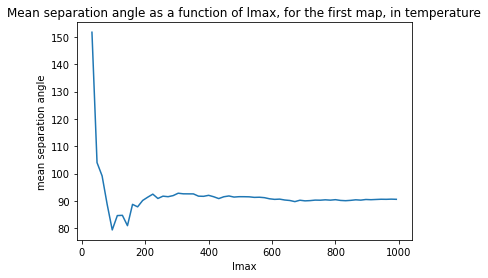

In [11]:
cos_theta = [] # np.shape = (number_of_maps, number_of_bins-1, Nb_bin(Nb_bin+1)/2 elements, 3(TT,EE,TE))
thetas = []
for nb_map in range(nb_maps):
    cos_theta_m = [] # cos(theta) between all pairs (so Nb_bin(Nb_bin+1)/2 elements, 3(TT,EE,TE))
    theta_m = [] # theta (in degrees) between all pairs, np.shape = (Nb_bin(Nb_bin+1)/2, 3(TT,EE,TE))
    
    for b in range(1,number_of_bins): # boucle qui prend a chaque fois tous les bins jusqu'à un certain point, pour avoir mean_sep en fonction de lmax
    #for k in range(3): # for TT,EE,TE
        cos_theta_b = []
        theta_b = []
        for i in range(b+1): # for each bin up to bin b included
            for j in range(1,b-i): # all the vectors after vector i and before bin b
                cos_TT_EE_TE = []
                theta_TT_EE_TE = []
                for k in range(3): # for TT,EE,TE
                    scalar_product = np.dot(maps[nb_map][i][k], maps[nb_map][i+j][k])
                    norms = np.linalg.norm(maps[nb_map][i][k])*np.linalg.norm(maps[nb_map][i+j][k])
                    cos_TT_EE_TE.append(scalar_product/norms)
                    theta_TT_EE_TE.append(np.degrees(np.arccos(scalar_product/norms)))
                cos_theta_b.append(cos_TT_EE_TE)
                theta_b.append(theta_TT_EE_TE)
        cos_theta_m.append(cos_theta_b)
        theta_m.append(theta_b)
    cos_theta.append(cos_theta_m)
    thetas.append(theta_m)

mean_sep_angle = [] # np.shape = (number_of_maps, number_of_bins-1, 3(TT,EE,TE))
for nb_map in range(nb_maps): # for each map
    #print('nb_map', nb_map)
    mean_sep_angle_m = [] # np.shape = (3(TT,EE,TE))
    #for b in range(len(theta[0])):
    #mean_sep_angle_b = []
    for k in range(3): # for TT,EE,TE
        #print('k',k)
        mean_sep_angle_b = [] # rename for mean_sep_angle_TT_EE_TE
        for b in range(1,len(thetas[nb_map])): # for each bin
            #print('b', b)
            mean_sep_angle_TT_EE_TE = 0 # rename for mean_sep_angle_b
            for angle in range(len(thetas[nb_map][b])):
                #print('angle',angle)
                mean_sep_angle_TT_EE_TE += thetas[nb_map][b][angle][k]
            mean_sep_angle_TT_EE_TE /= len(thetas[nb_map][b]) # divide by the number of bins that were counted
            mean_sep_angle_b.append(mean_sep_angle_TT_EE_TE)
        mean_sep_angle_m.append(mean_sep_angle_b)
    mean_sep_angle.append(mean_sep_angle_m)
    
#print('mean separation angle for TT:', np.array(mean_sep_angle).T[-1][0], 'degrees') # values when all the pairs
#print('mean separation angle for EE:', np.array(mean_sep_angle).T[-1][1], 'degrees') # of bins were used
#print('mean separation angle for TE:', np.array(mean_sep_angle).T[-1][2], 'degrees')

# Plot, for the first map, of the mean separation angle as a function of lmax, for temperature
y = mean_sep_angle[0][0] # first map, temperature
x = [bin_*bin_size for bin_ in range(2,number_of_bins)]
plt.plot(x,y)
plt.xlabel('lmax')
plt.ylabel('mean separation angle')
plt.title('Mean separation angle as a function of lmax, for the first map, in temperature')
plt.show()

### Histograms in $cos \theta$ and $\phi$ :

In [13]:
lats = [] # np.shape = (number_of_bins, 3(TT,EE,TE), nb_maps) containging the latitudes
lons = [] # np.shape = (number_of_bins, 3(TT,EE,TE), nb_maps) containging the longitudes
amps = [] # np.shape = (number_of_bins, 3(TT,EE,TE), nb_maps) containging the amplitudes

for bin_ in range(number_of_bins):
    bin_lats = []
    bin_lons = []
    bin_amps = []
    for TT_EE_TE in range(3):
        TT_EE_TE_lats = []
        TT_EE_TE_lons = []
        TT_EE_TE_amps = []
        for map_ in range(len(maps)): # the total number of maps
            lat, lon, amp = retrieve_angles(maps[map_][bin_][TT_EE_TE])
            TT_EE_TE_lats.append(lat)
            TT_EE_TE_lons.append(lon)
            TT_EE_TE_amps.append(amp)
        bin_lats.append(TT_EE_TE_lats)
        bin_lons.append(TT_EE_TE_lons)
        bin_amps.append(TT_EE_TE_amps)
    lats.append(bin_lats)
    lons.append(bin_lons)
    amps.append(bin_amps)


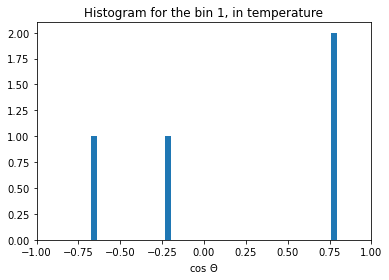

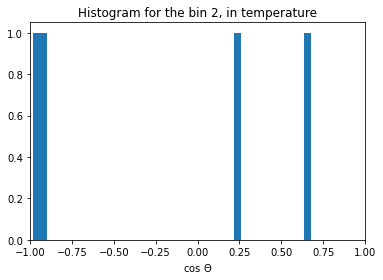

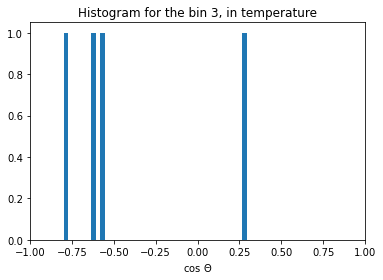

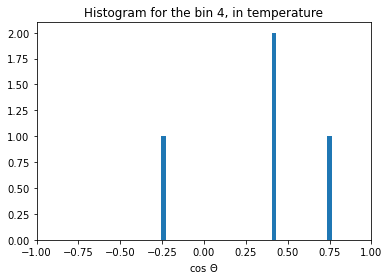

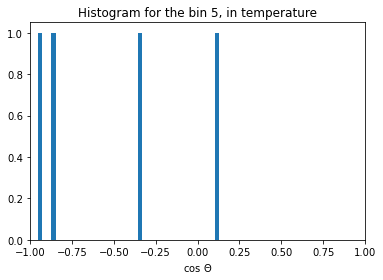

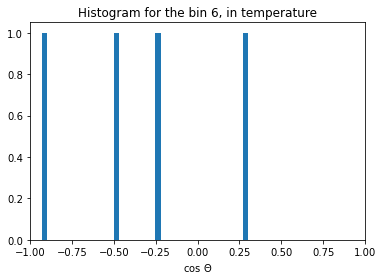

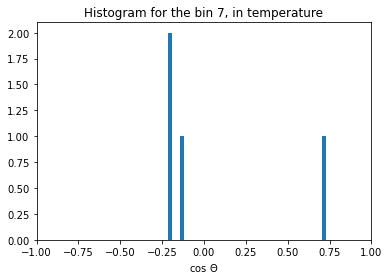

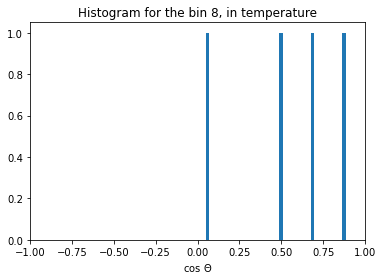

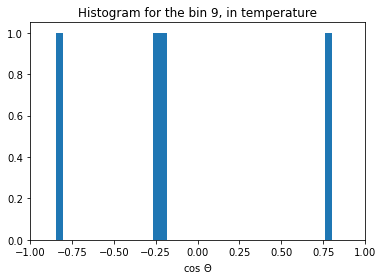

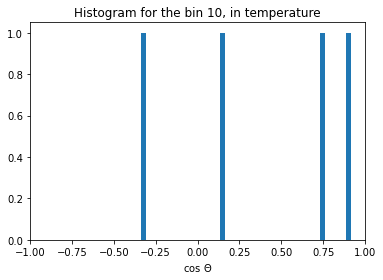

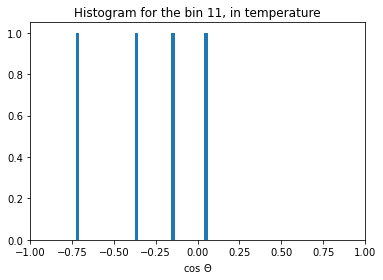

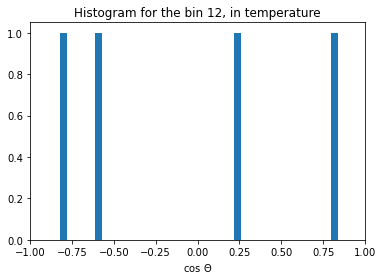

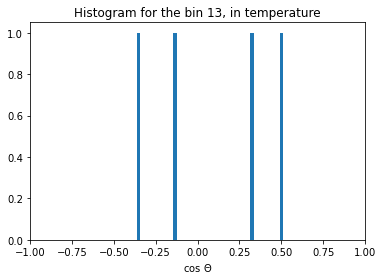

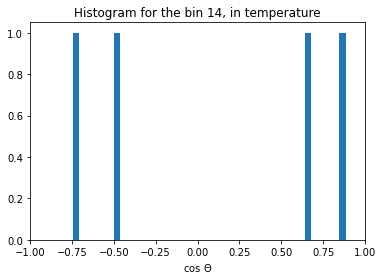

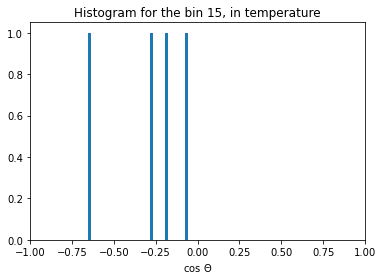

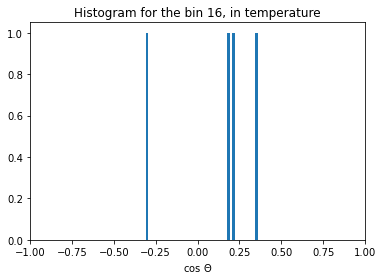

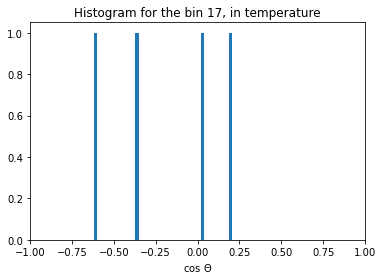

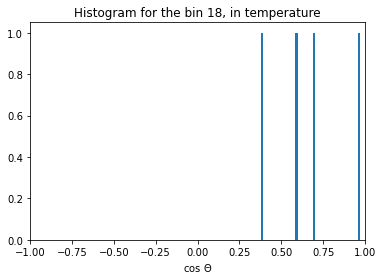

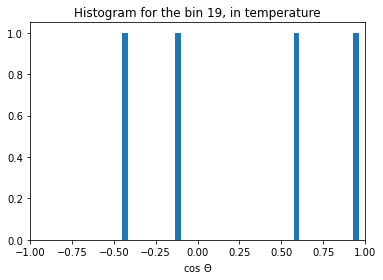

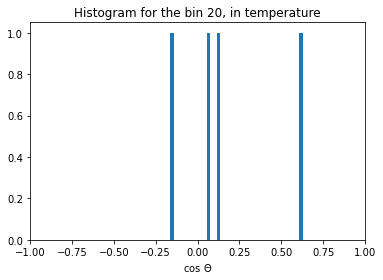

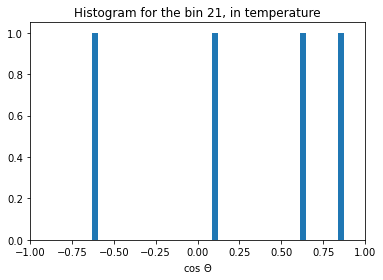

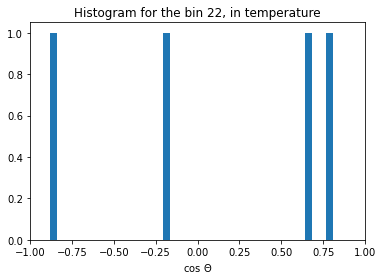

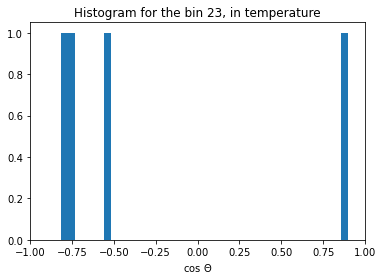

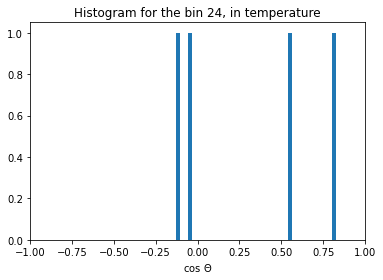

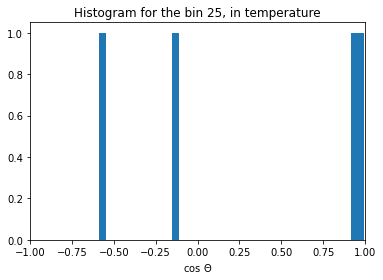

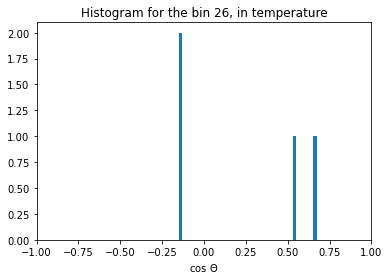

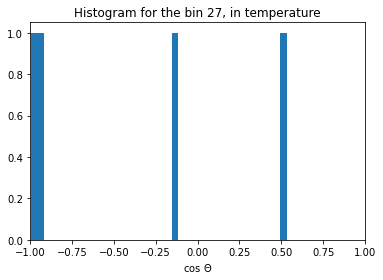

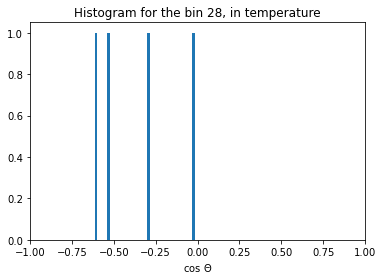

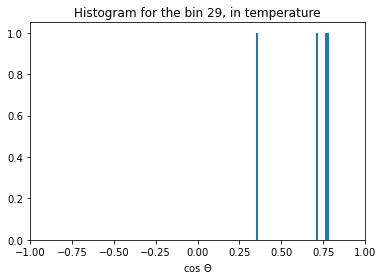

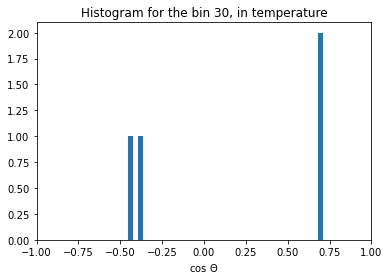

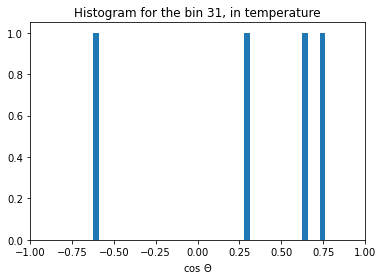

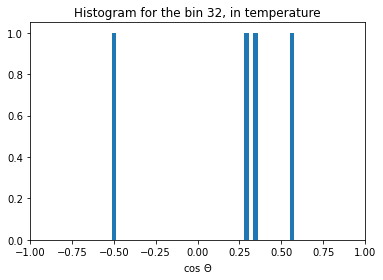

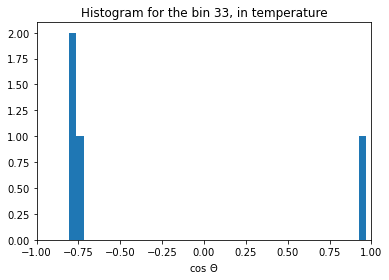

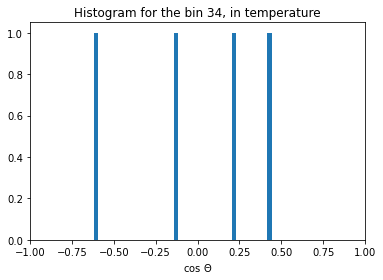

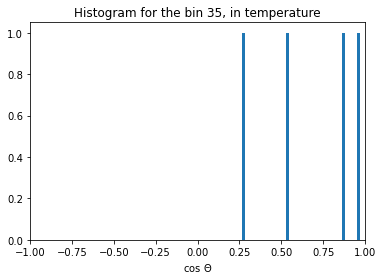

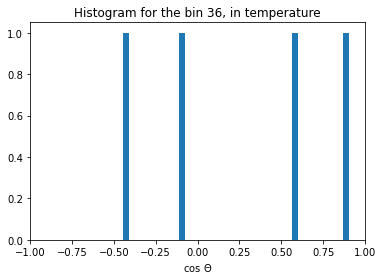

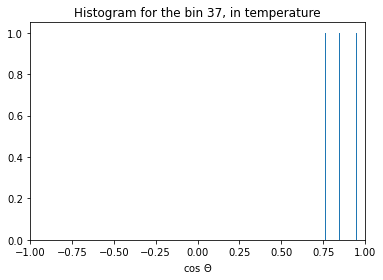

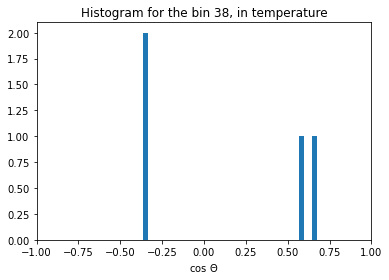

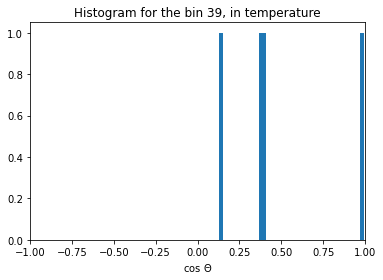

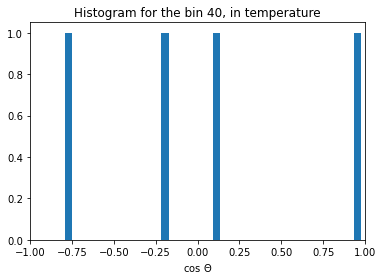

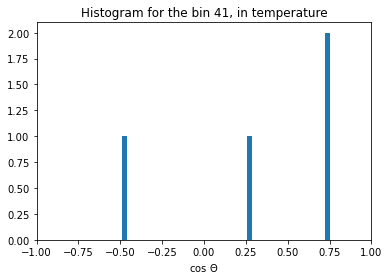

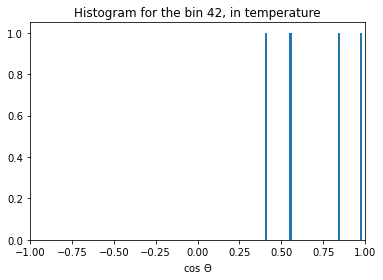

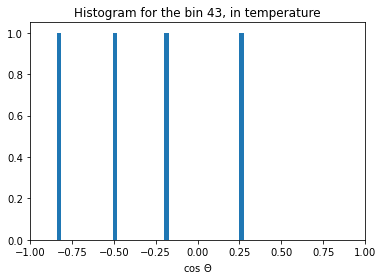

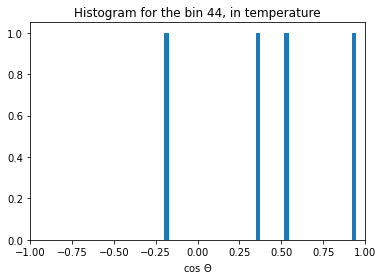

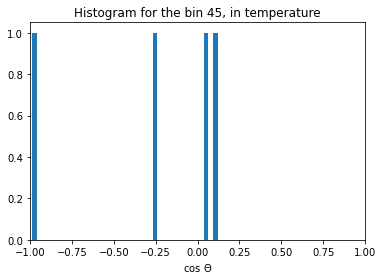

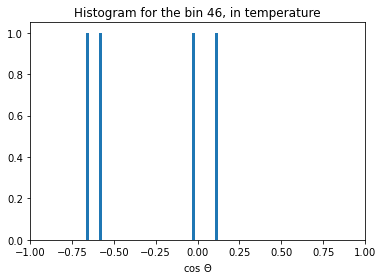

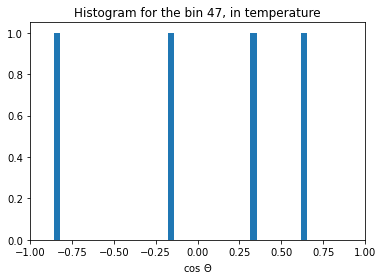

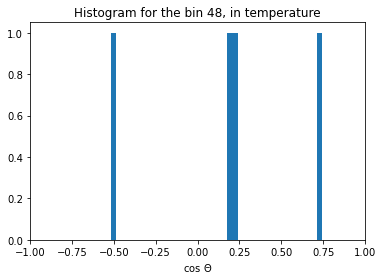

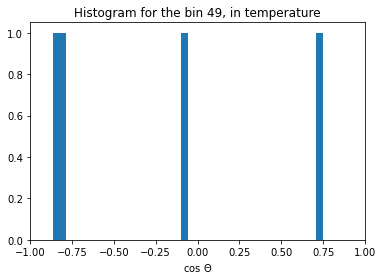

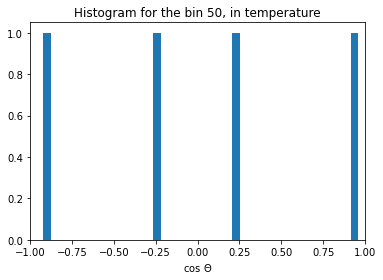

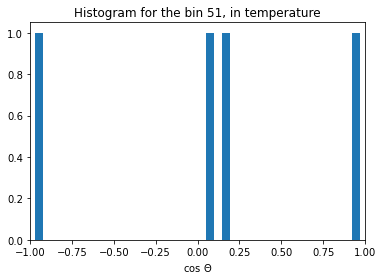

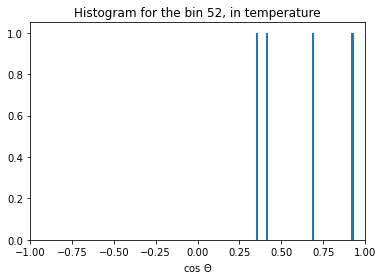

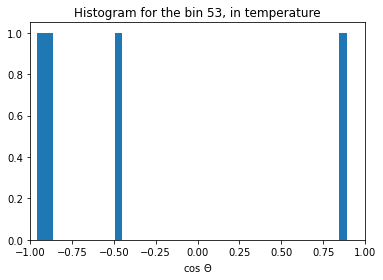

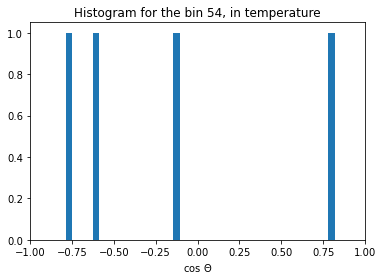

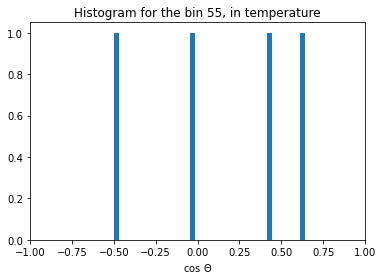

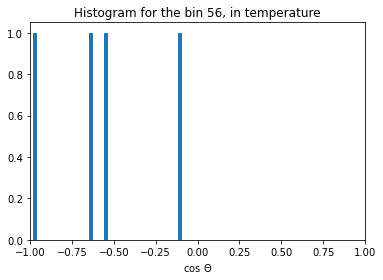

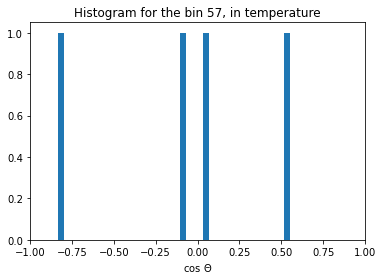

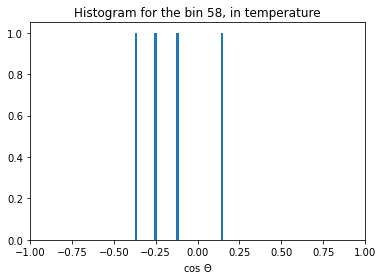

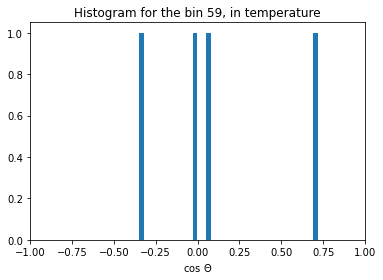

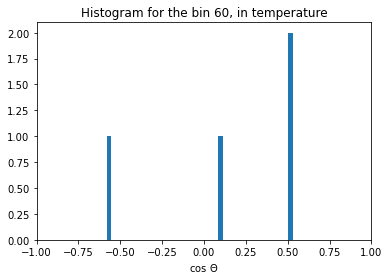

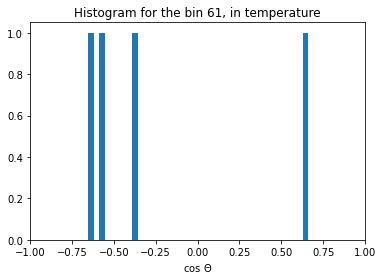

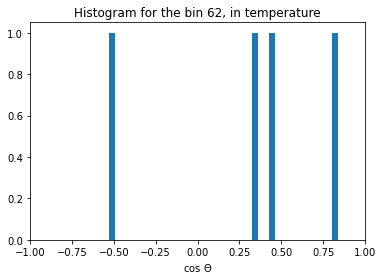

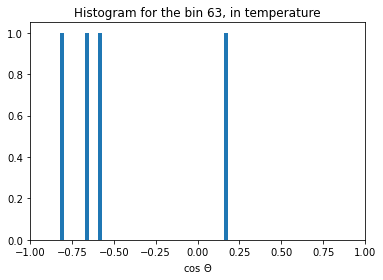

In [78]:
cos_lats = np.cos(np.radians(np.array(lats)+90))
for bin_ in range(number_of_bins):
    plt.hist(cos_lats[bin_][0], density=False, bins=40)
    plt.xlabel('cos $\Theta$')
    plt.xlim([-1,1])
    plt.title('Histogram for the bin %s, in temperature'%(bin_+1))
    plt.show()
#plt.savefig('histogram_cos_theta.png')

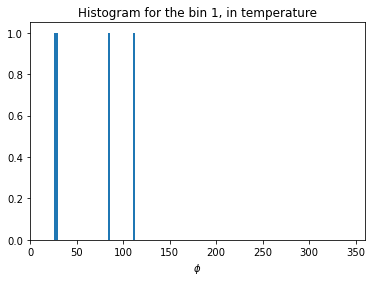

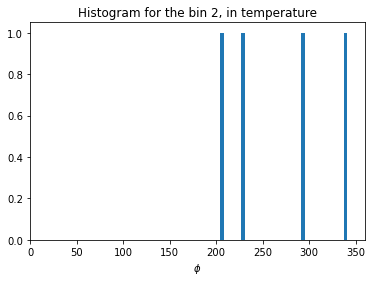

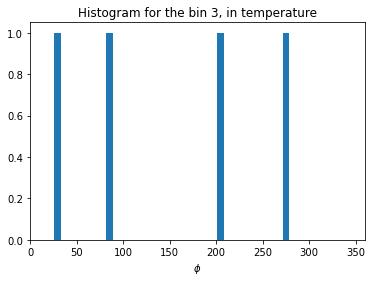

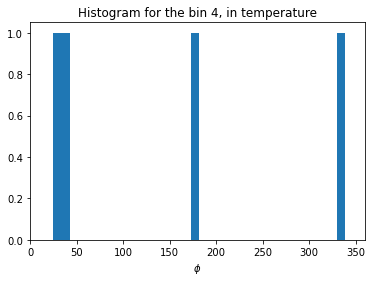

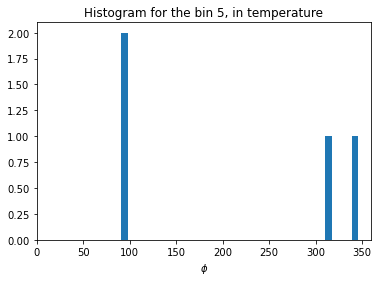

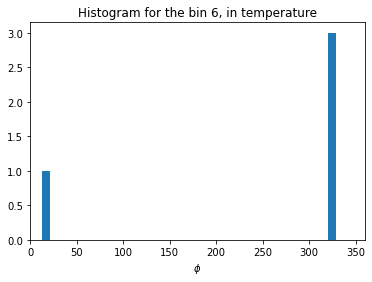

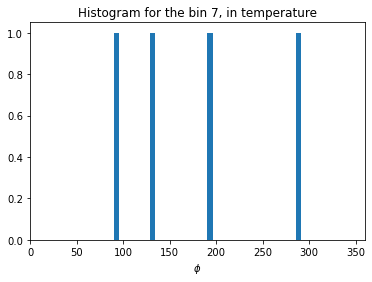

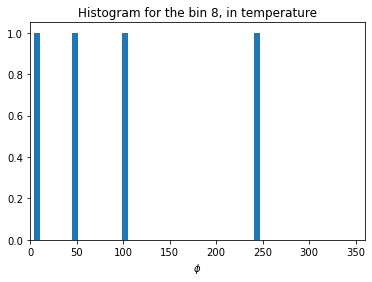

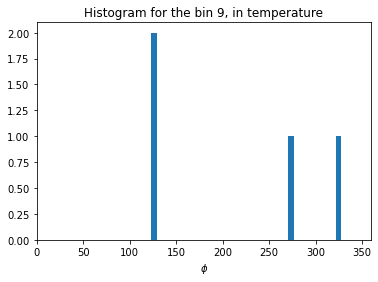

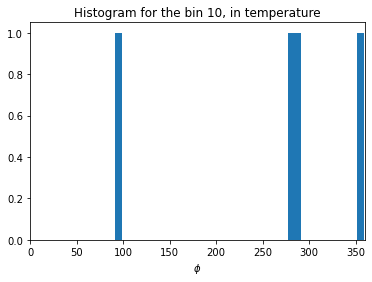

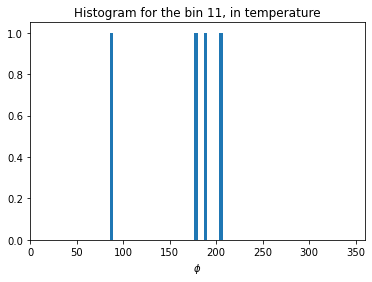

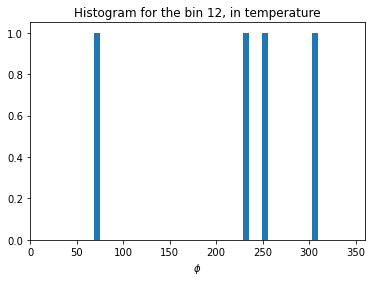

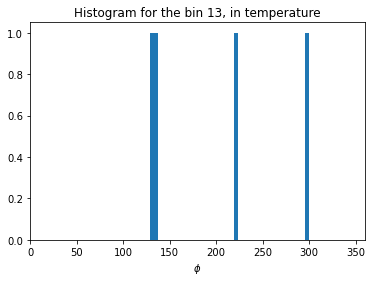

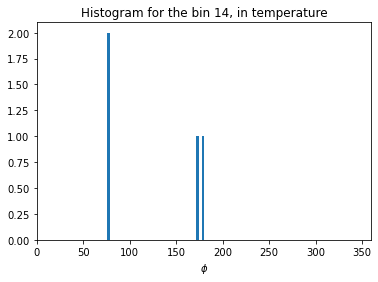

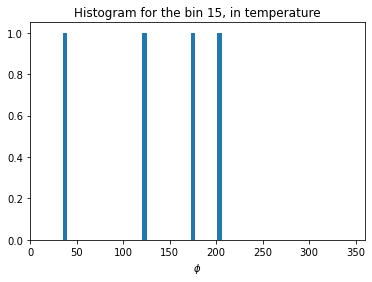

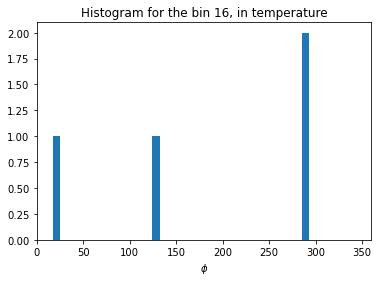

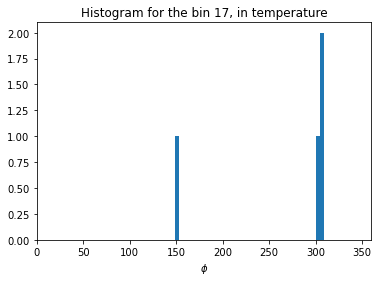

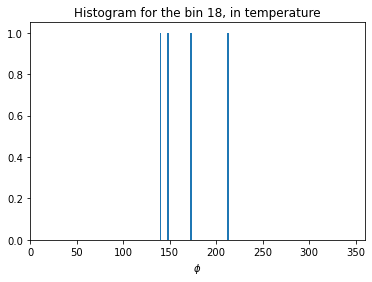

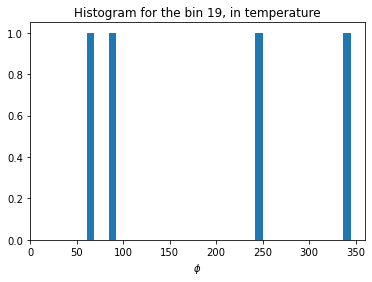

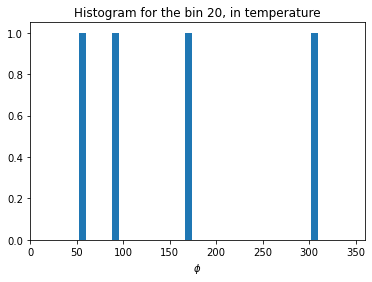

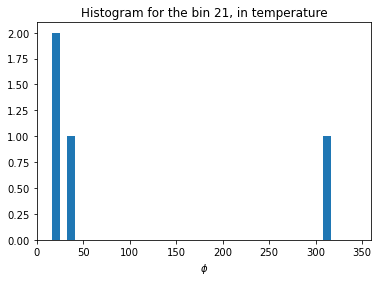

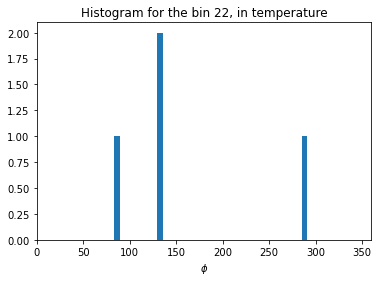

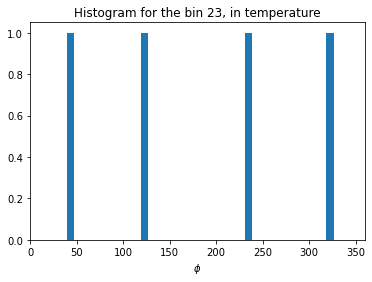

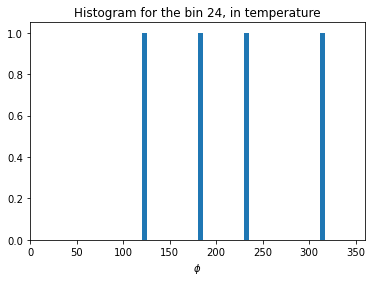

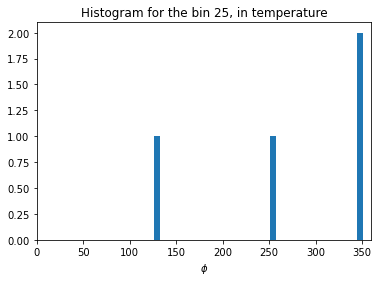

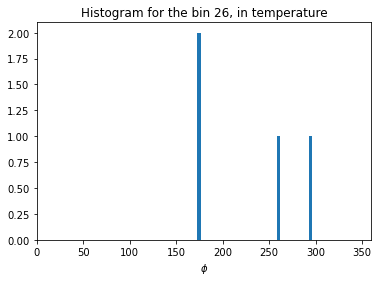

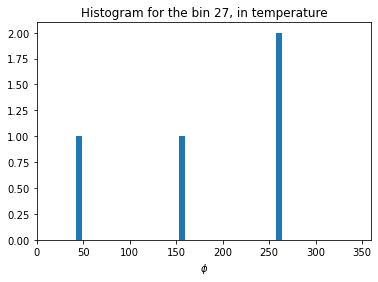

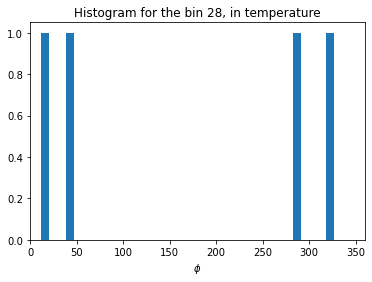

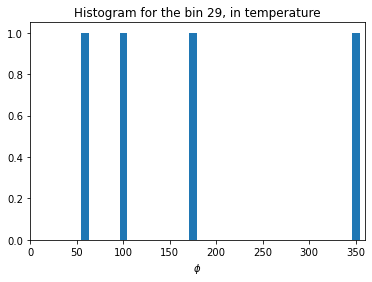

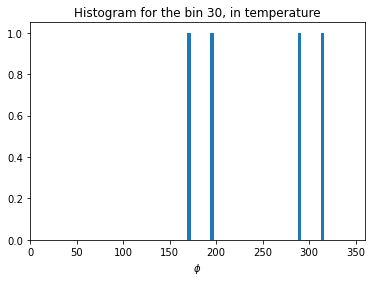

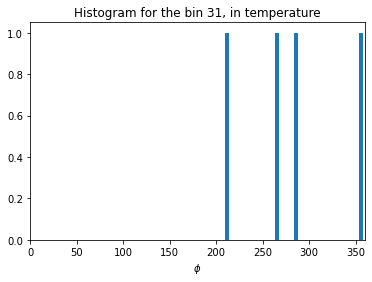

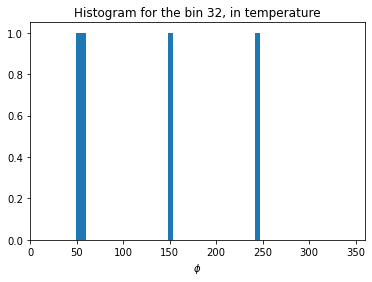

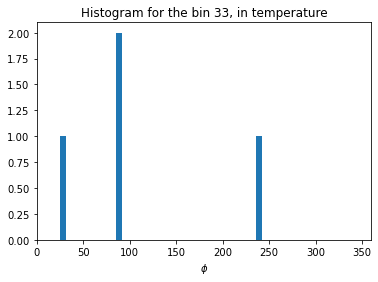

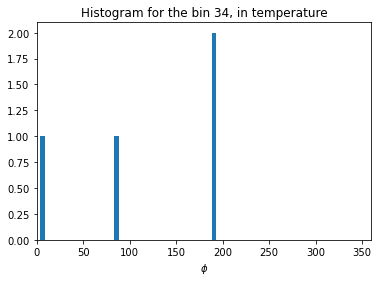

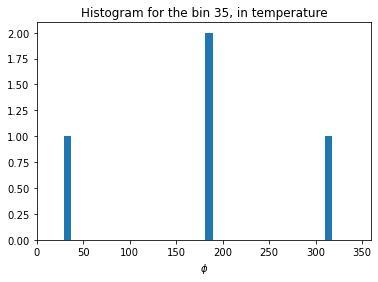

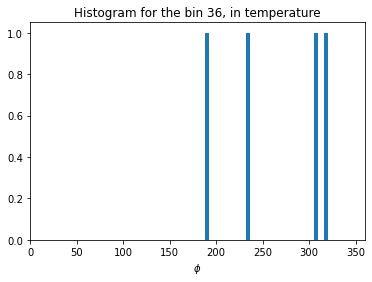

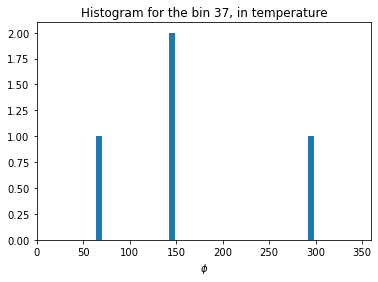

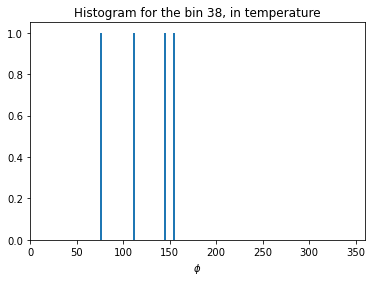

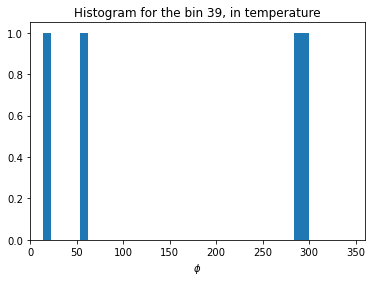

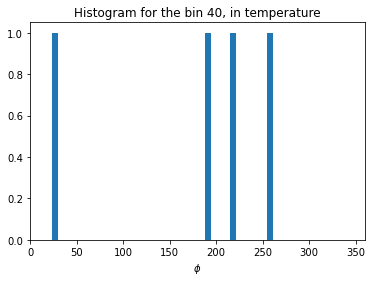

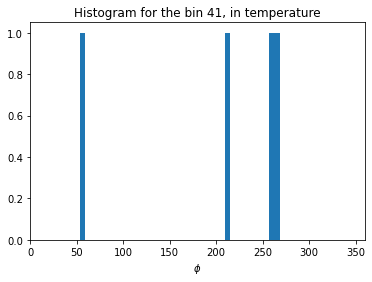

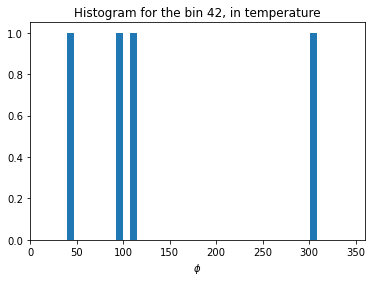

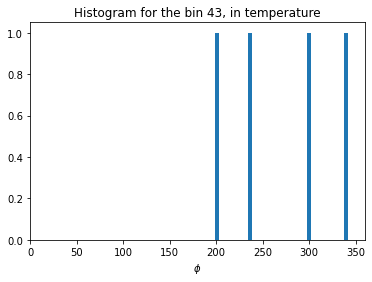

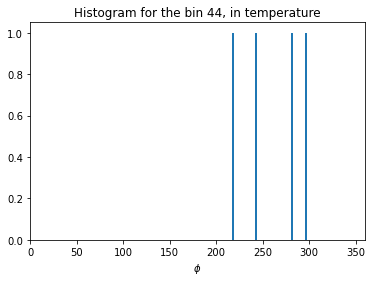

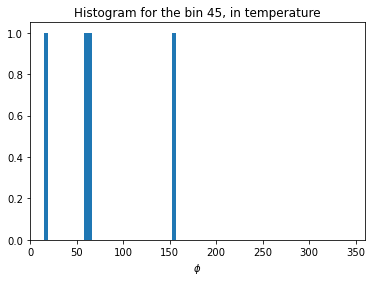

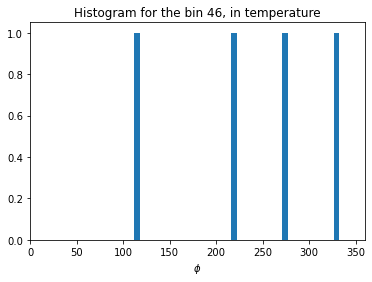

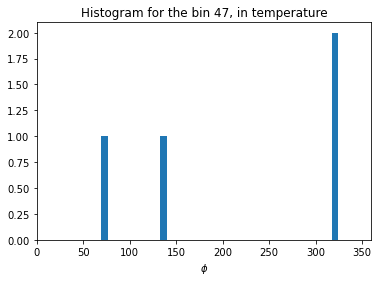

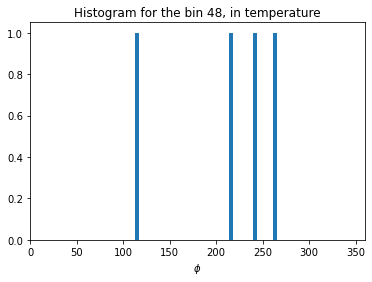

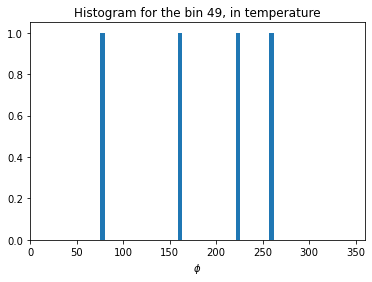

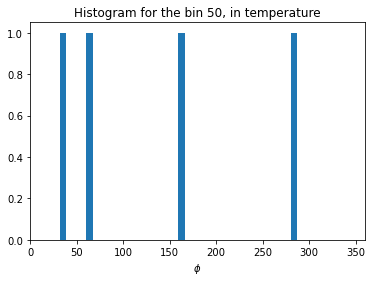

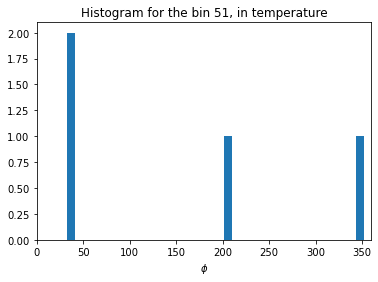

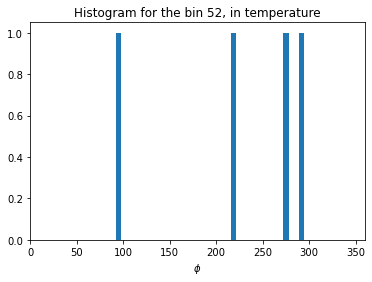

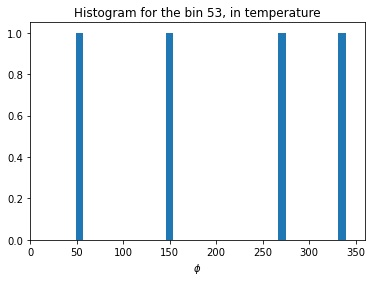

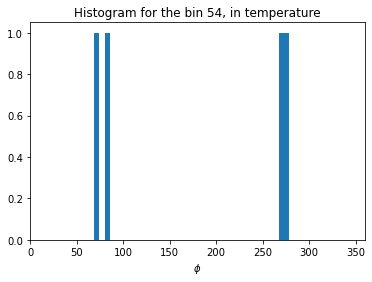

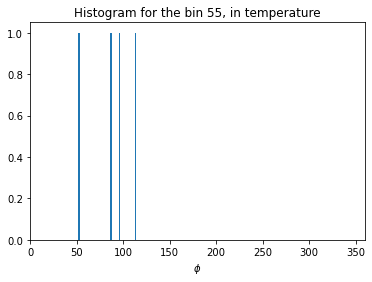

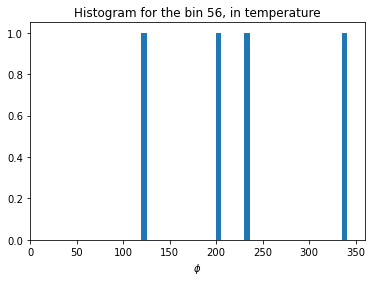

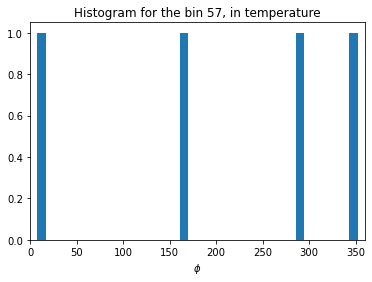

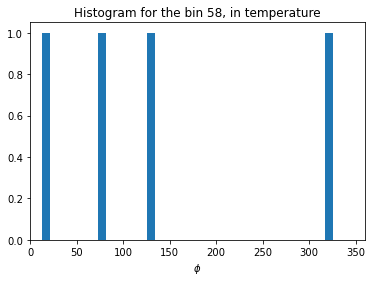

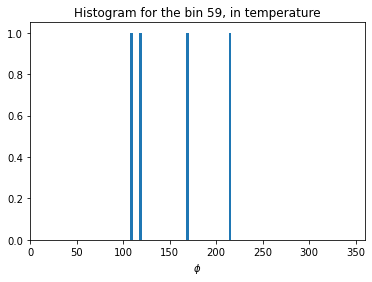

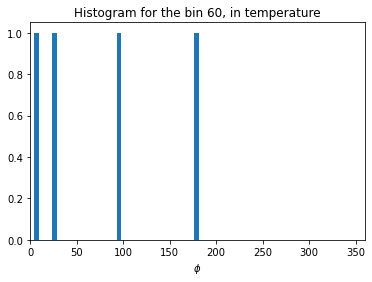

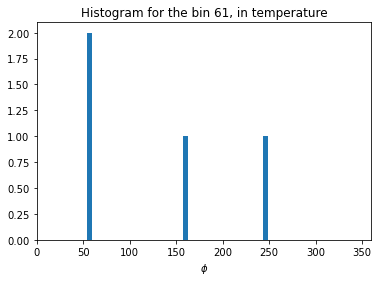

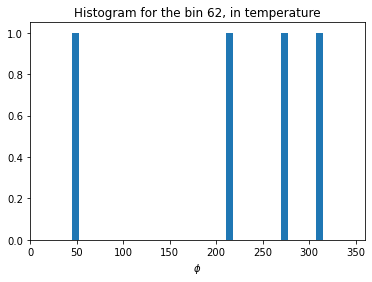

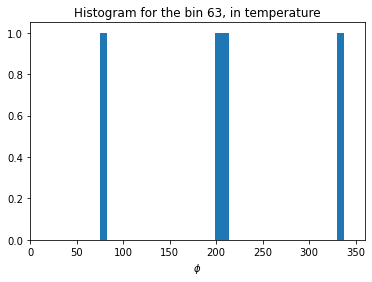

In [15]:
for bin_ in range(number_of_bins):
    plt.hist(lons[bin_][0], density=False, bins=36)
    plt.xlabel('$\phi$')
    plt.xlim([0,360])
    plt.title('Histogram for the bin %s, in temperature'%(bin_+1))
    plt.show()

### Maps showing the dipole directions:

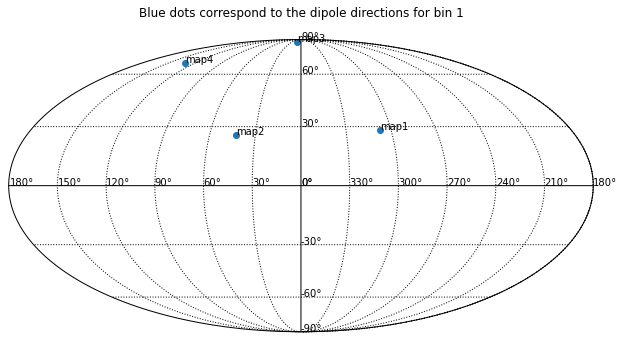

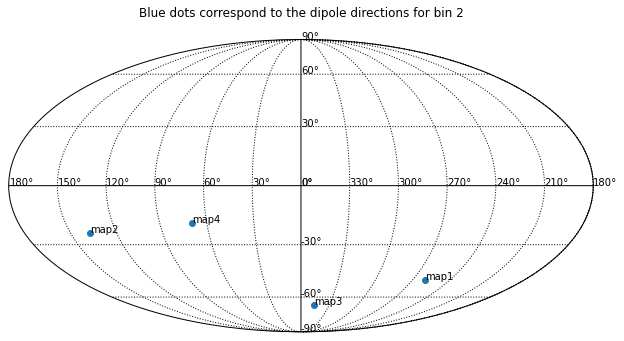

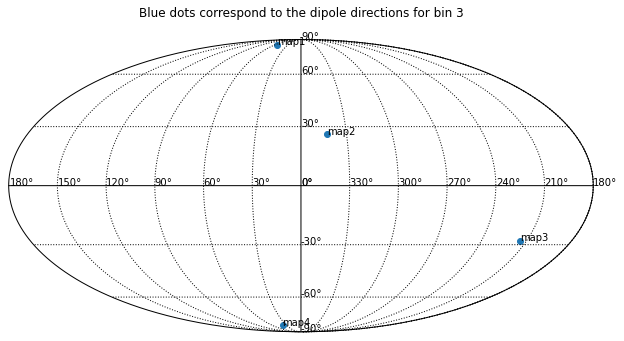

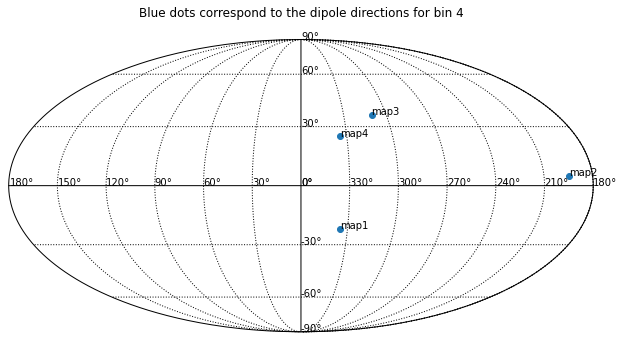

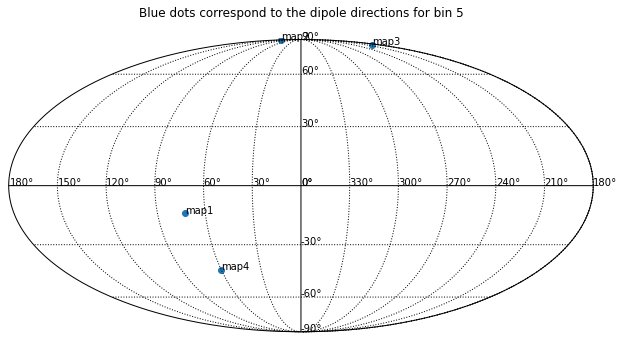

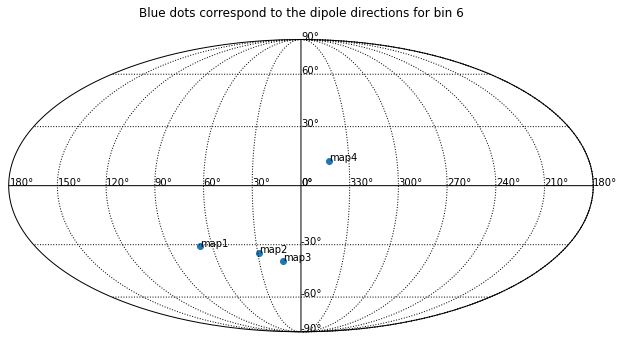

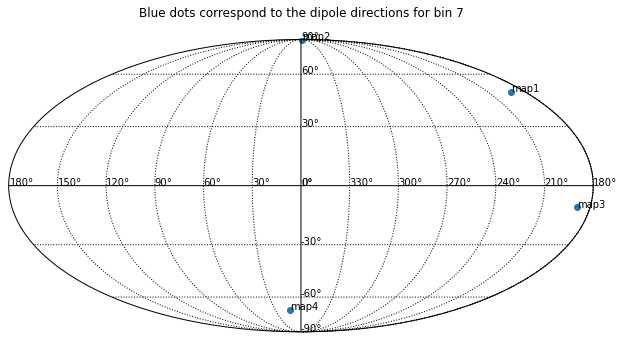

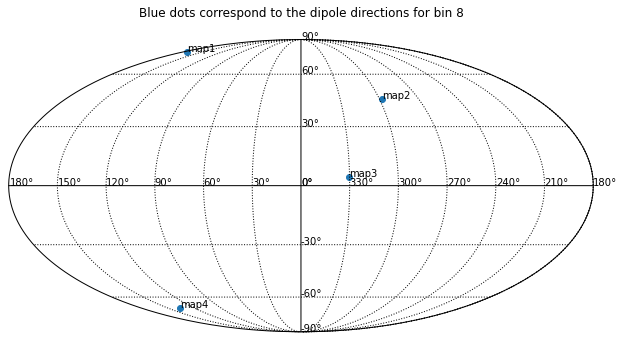

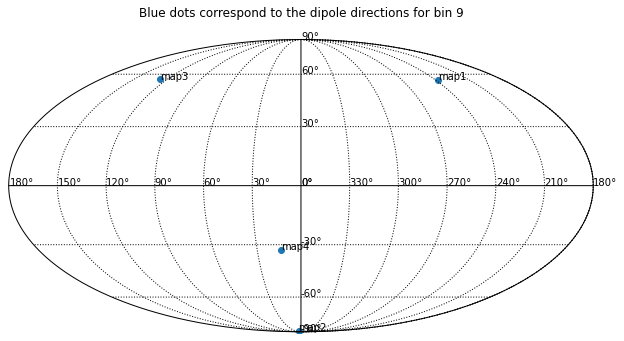

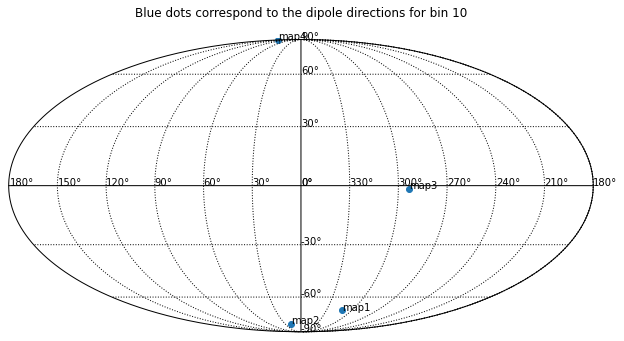

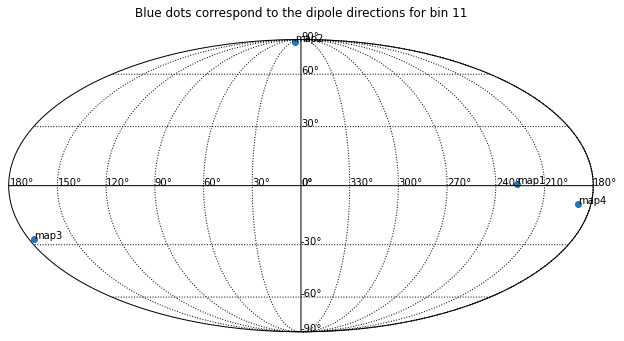

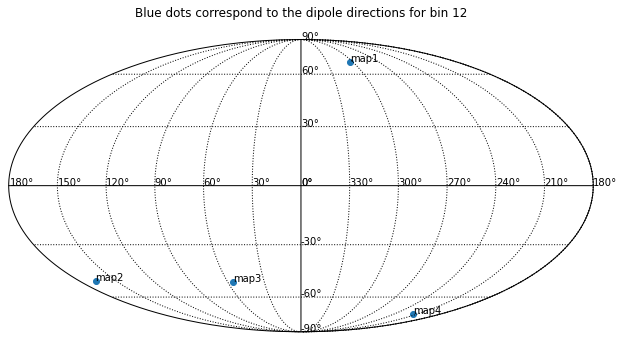

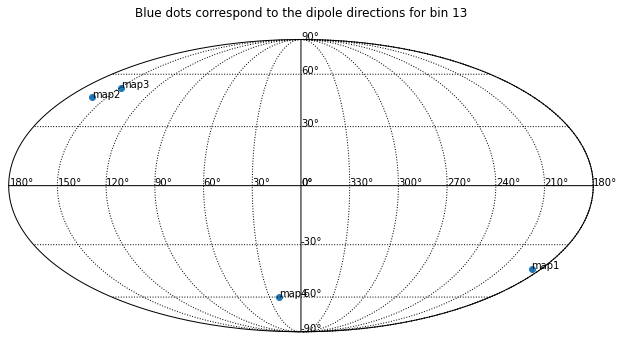

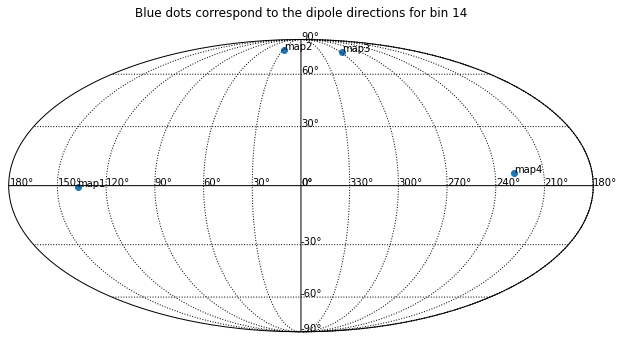

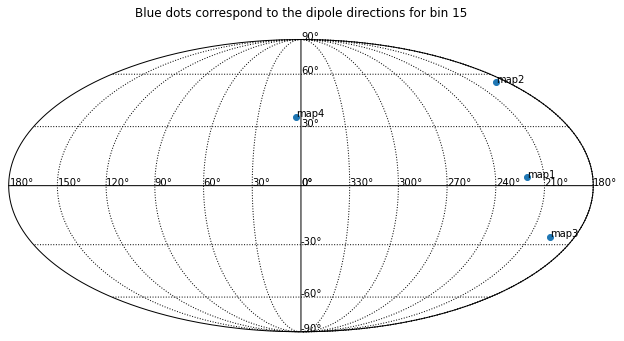

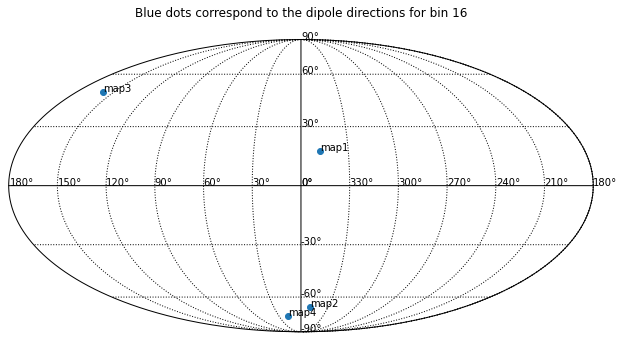

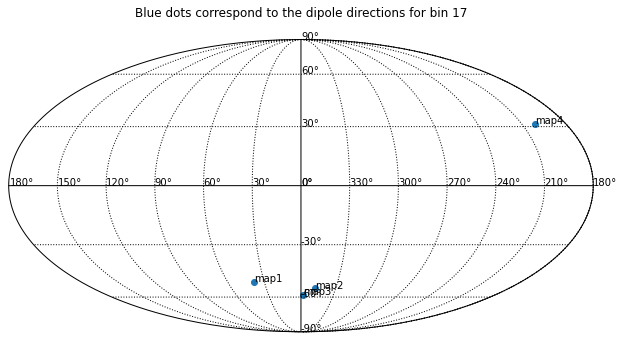

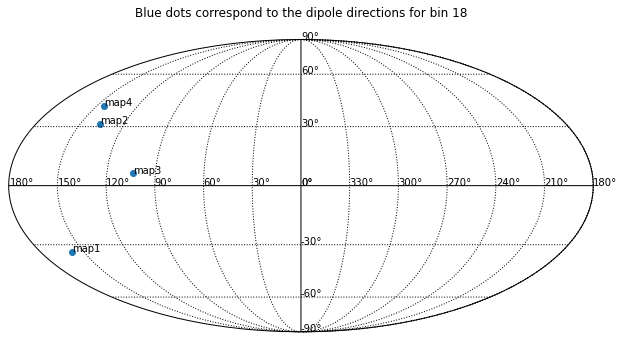

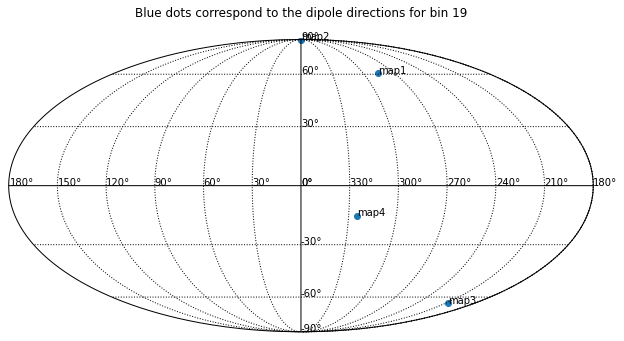

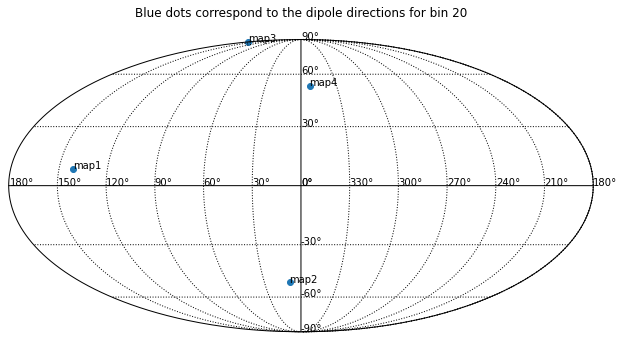

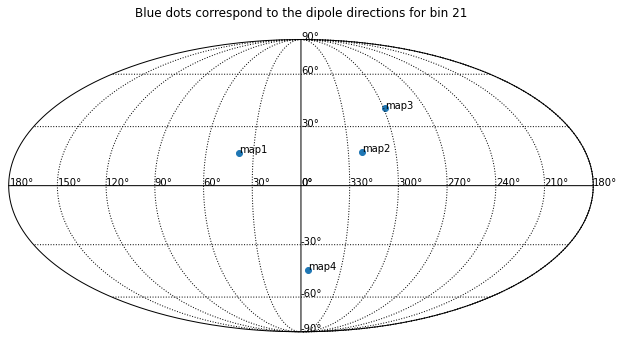

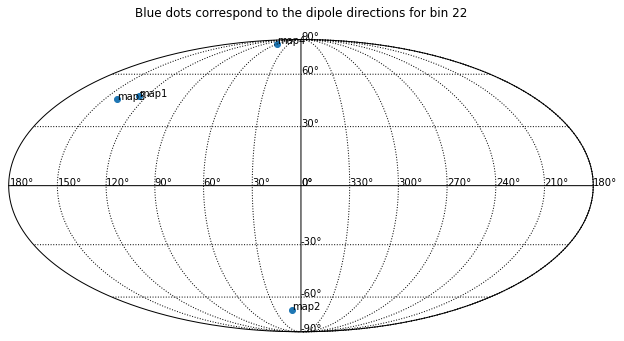

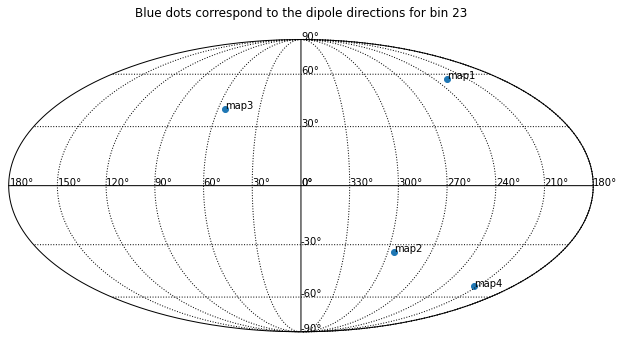

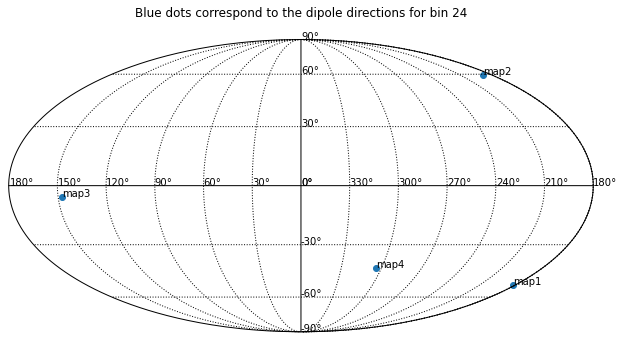

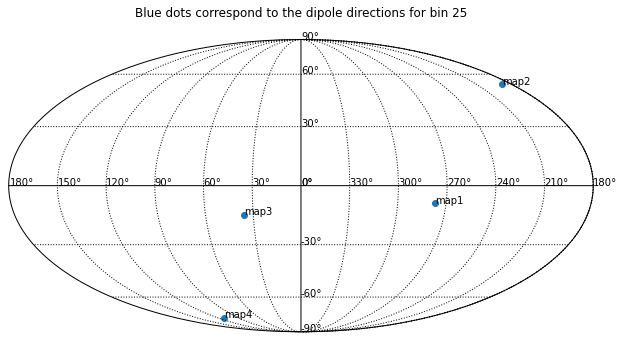

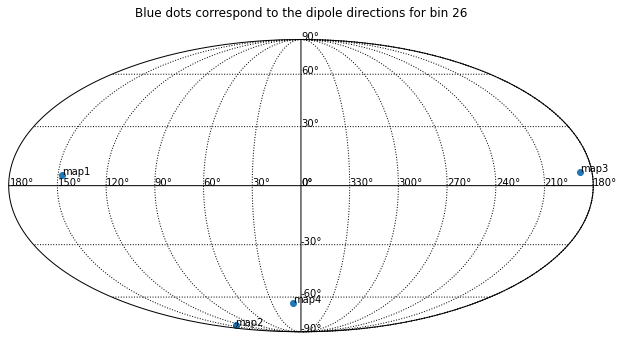

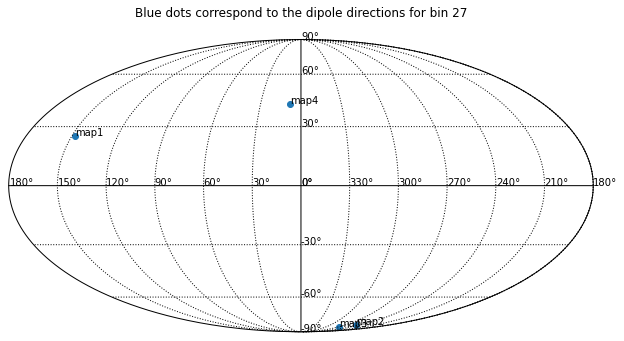

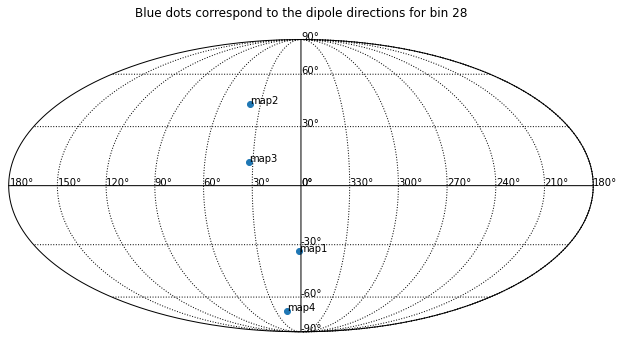

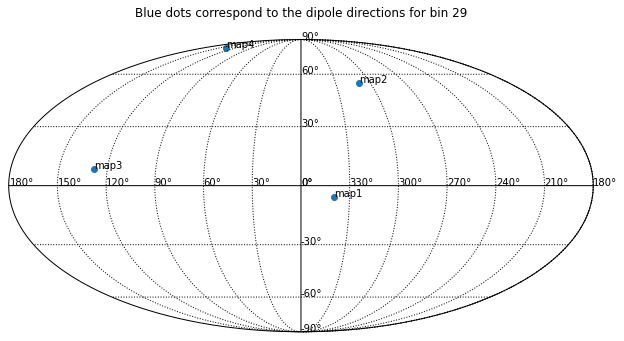

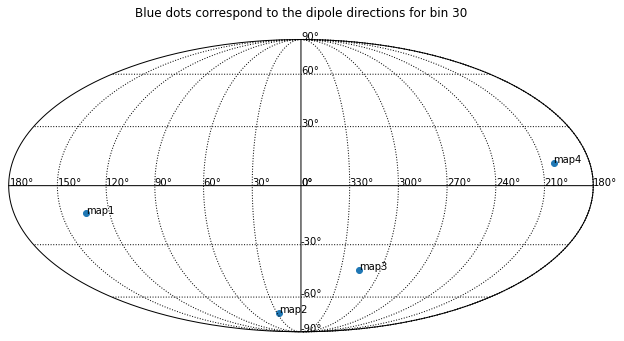

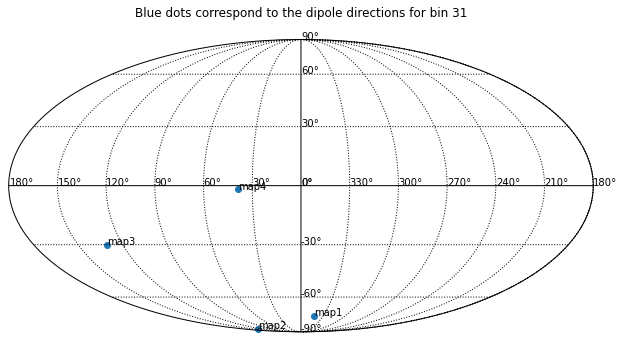

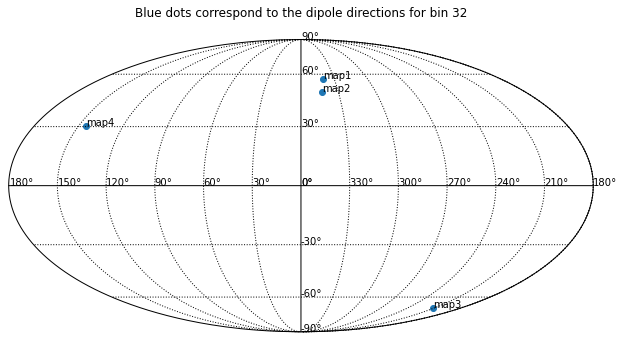

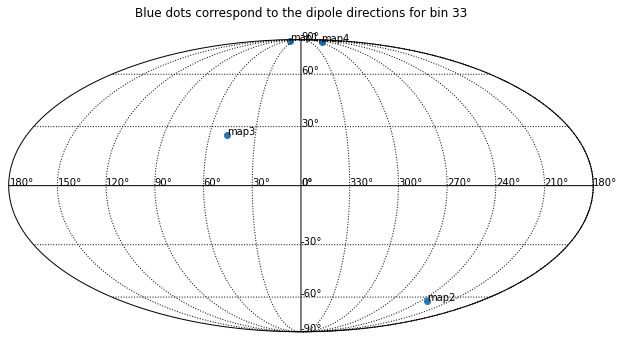

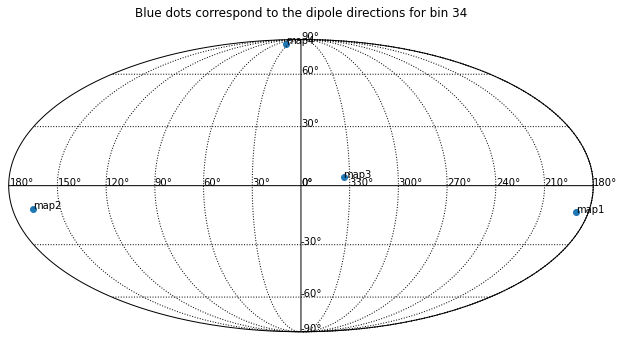

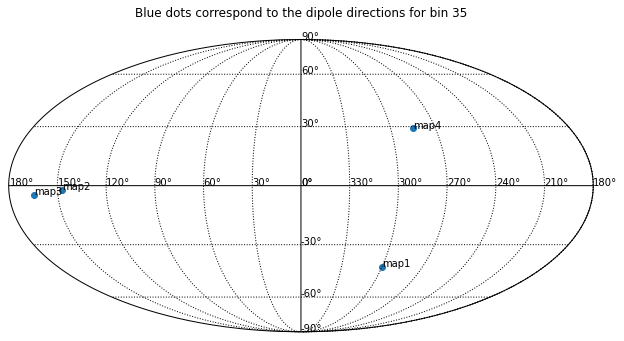

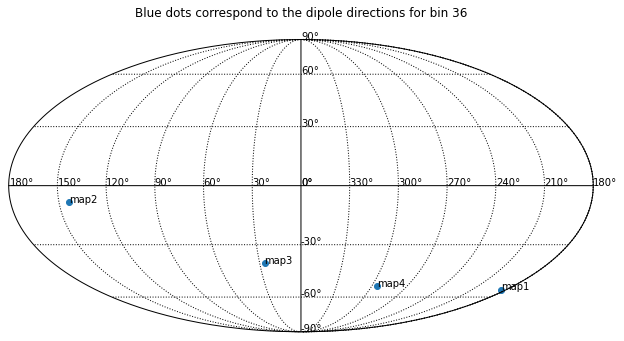

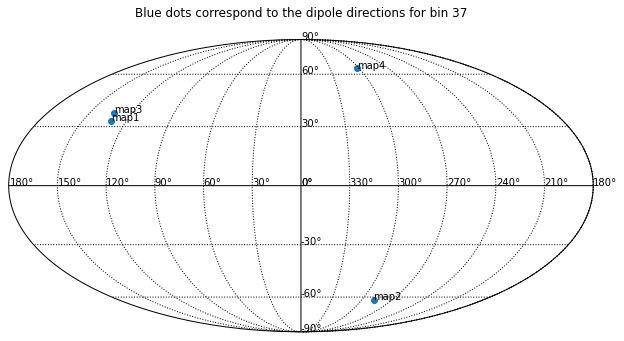

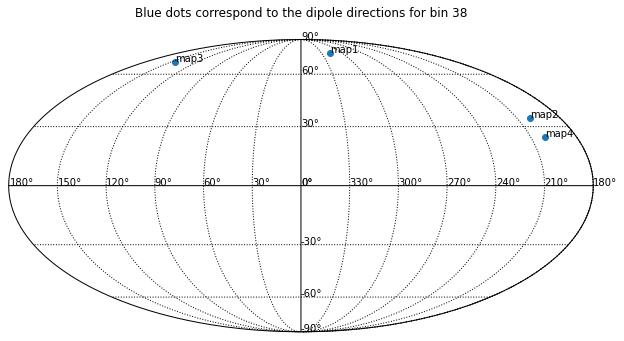

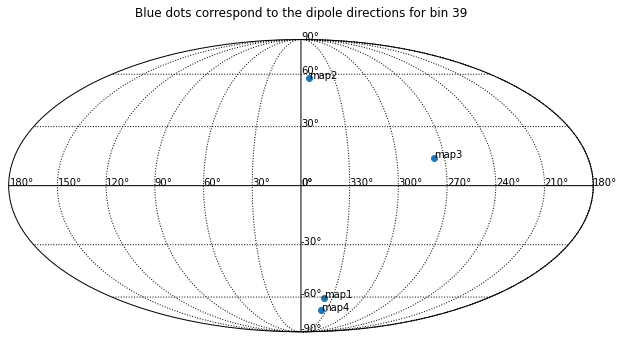

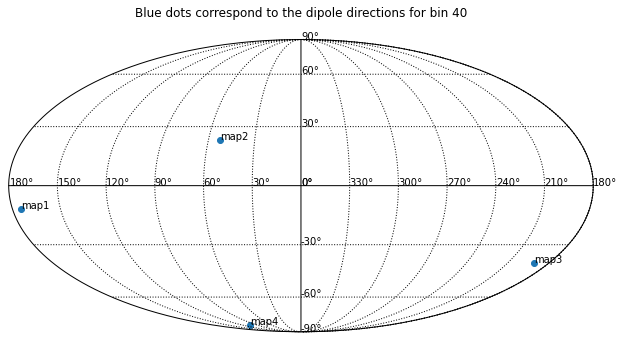

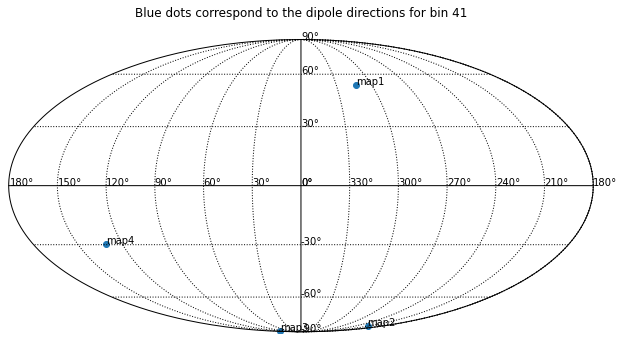

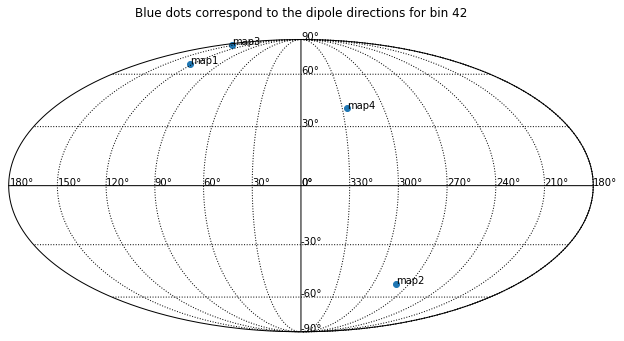

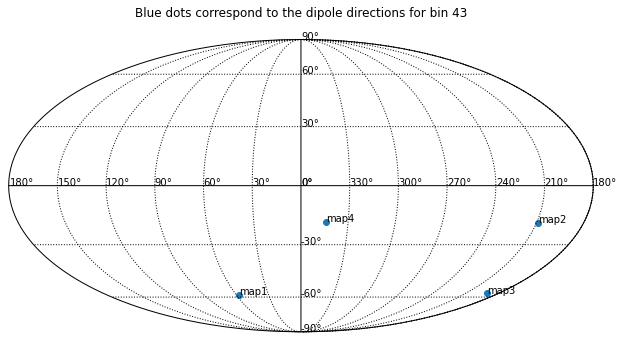

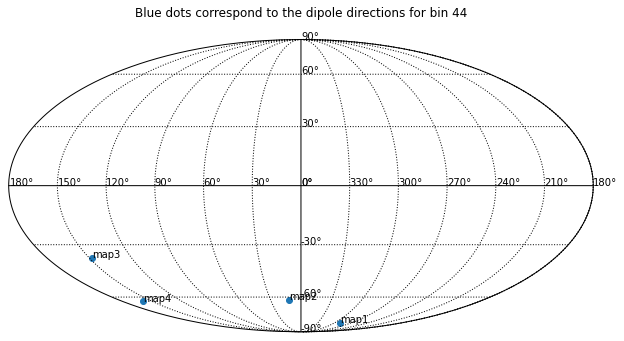

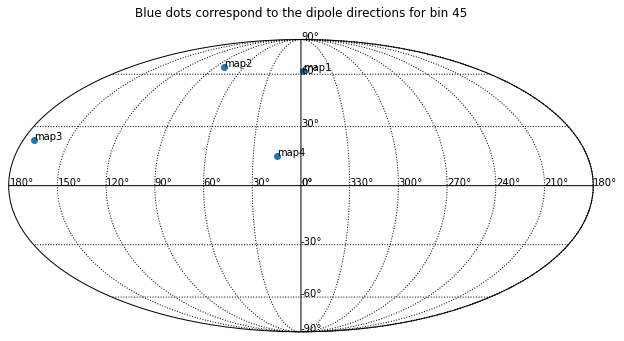

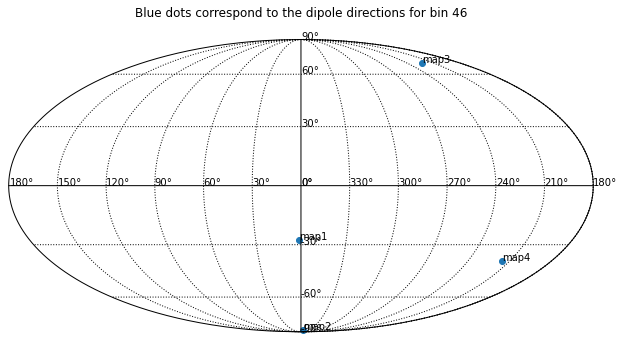

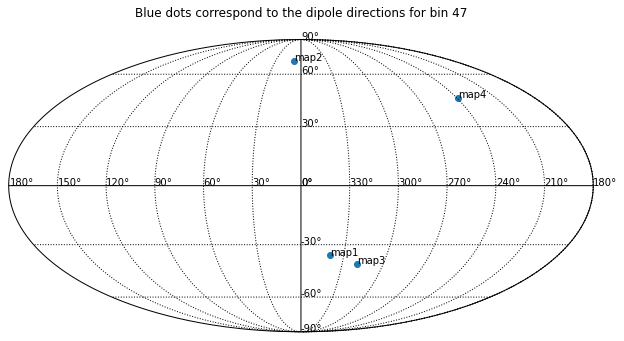

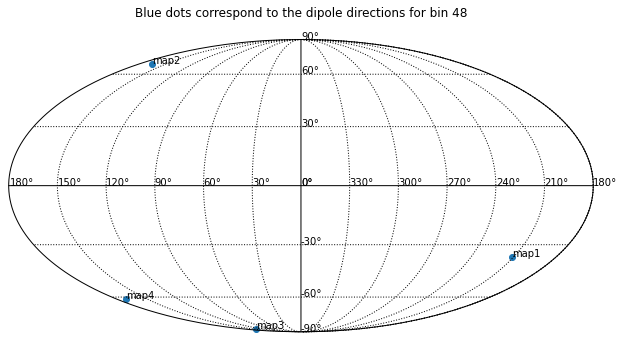

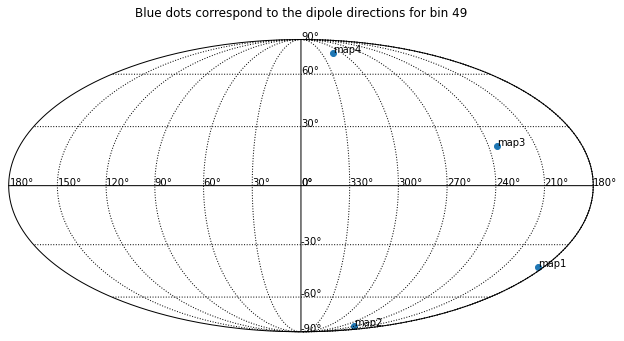

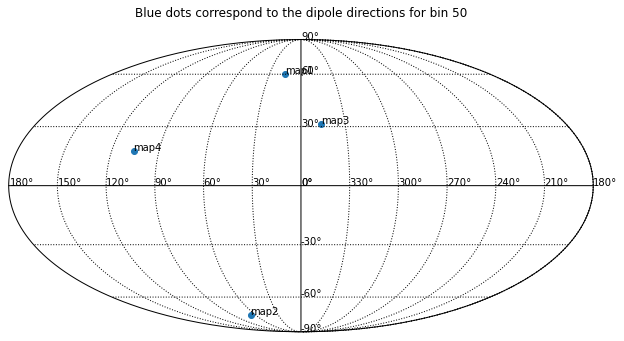

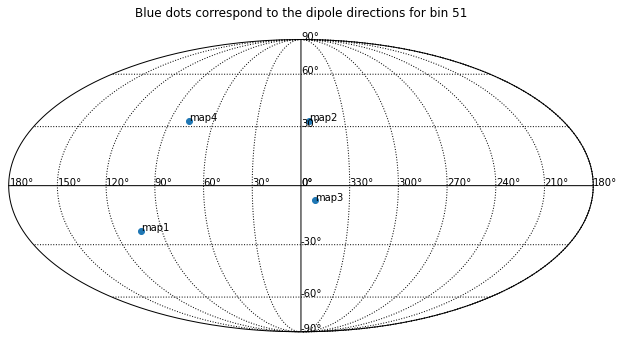

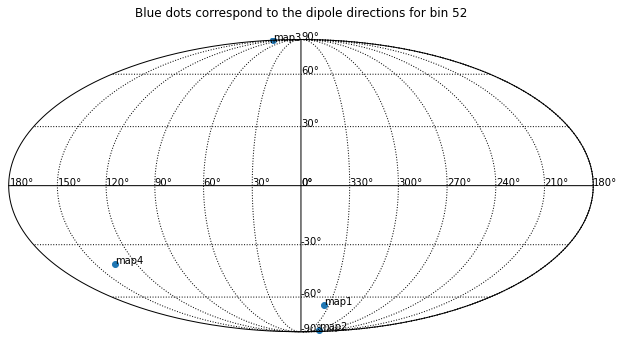

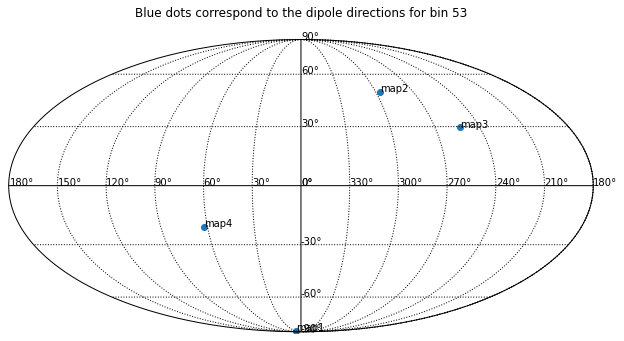

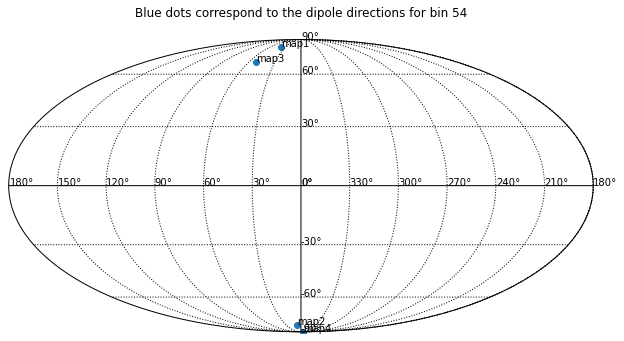

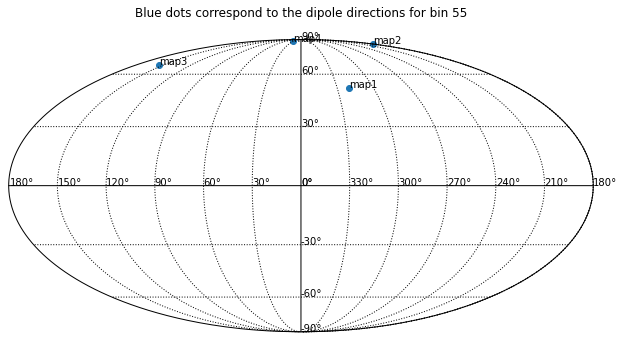

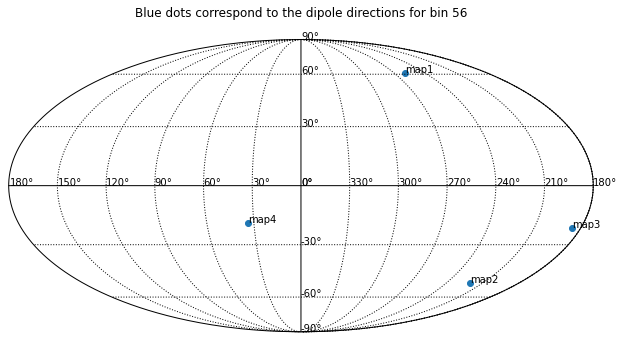

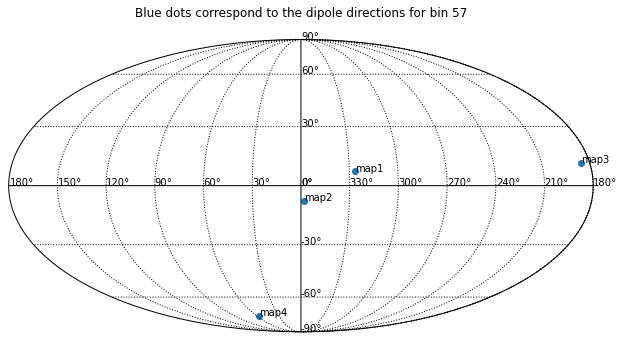

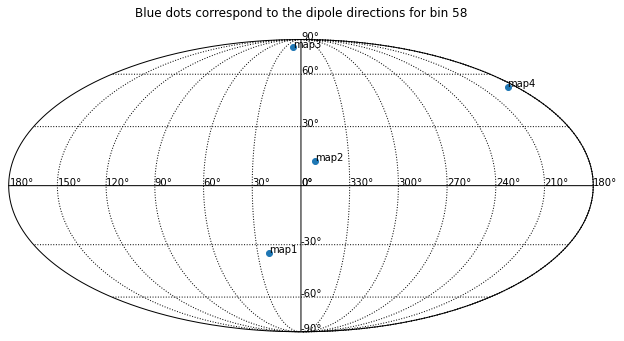

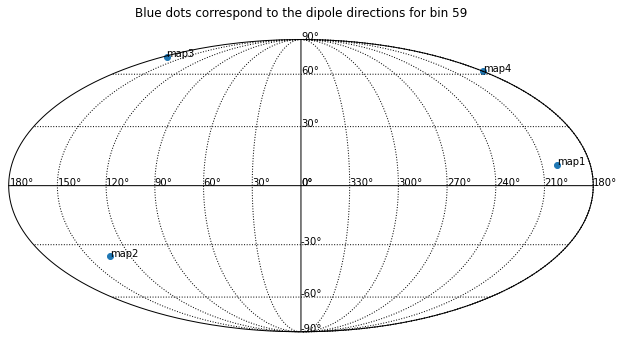

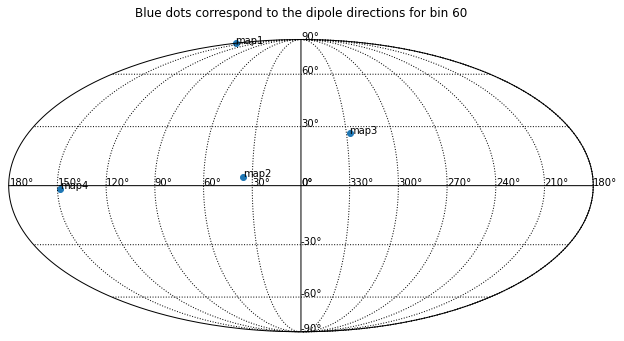

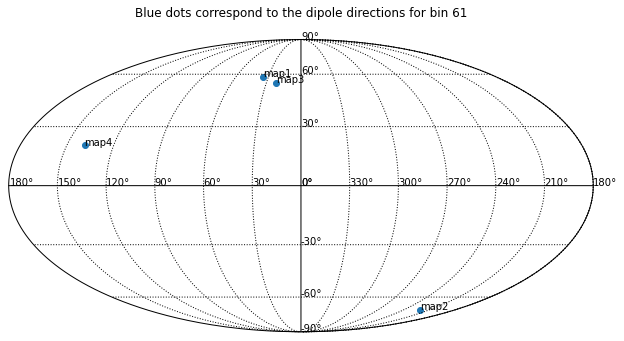

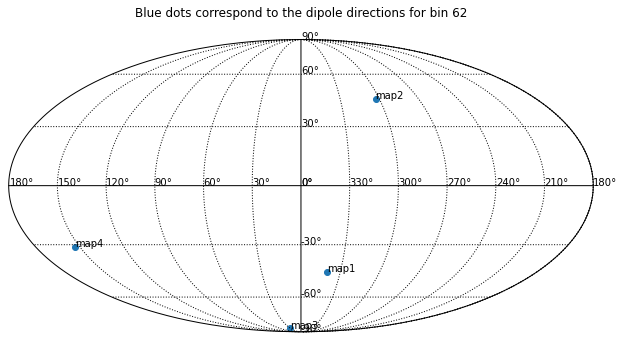

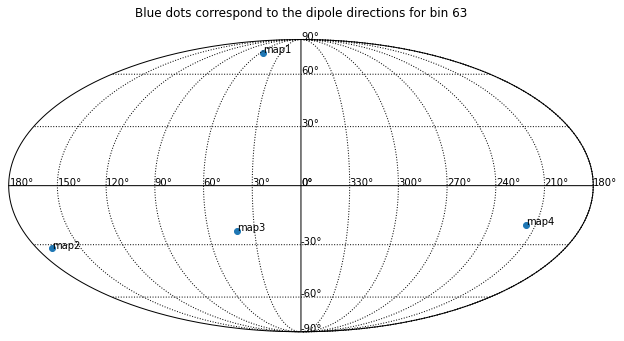

In [18]:
for bin_ in range(number_of_bins):
    hp.mollview(title='Blue dots correspond to the dipole directions for bin %s\n'%(bin_+1))
    hp.graticule()
    
    x_lon = [0,30,60,90,120,150,179,180,210,240,270,300,330]
    y_lon = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    lab_lon = ['0°','30°','60°','90°','120°','150°','180°','180°','210°','240°','270°','300°','330°']
    for i in range(len(x_lon)):
        hp.projtext(x_lon[i],y_lon[i], str(lab_lon[i]), lonlat=True)

    x_lat = [0,0,0,0,0,0,0]
    y_lat = [0,30,60,90,-90,-60,-30]
    lab_lat = ['0°','30°','60°','90°','-90°','-60°','-30°']
    for i in range(len(x_lat)):
        hp.projtext(x_lat[i],y_lat[i], str(lab_lat[i]), lonlat=True)
    
    hp.projscatter(lats[bin_][0],lons[bin_][0],lonlat=True)
    lab = ['map1', 'map2', 'map3', 'map4']
    for map_ in range(nb_maps):
        hp.projtext(lats[bin_][0][map_],lons[bin_][0][map_], str(lab[map_]), lonlat=True)
    plt.show()

### Simulation of maps with random distribution:

Random maps created from random Cls:

In [22]:
map_random_cls = []
for i in range(100):
    cls = np.random.rand(lmax)*1e4
    map_random_cls.append(hp.synfast(cls, nside, lmax=lmax, pol=True, pixwin=False,
                                     fwhm=0.0, sigma=None, new=True, verbose=True))
remove_random_cls = []
for i in range(len(map_random_cls)):
    remove_random_cls.append(hp.remove_dipole(map_random_cls[i], nest=False, fitval=True, copy=True))
    
angles_random_cls = []
for i in range(len(remove_random_cls)):
    angles_random_cls.append(retrieve_angles(remove_random_cls[i][2]))

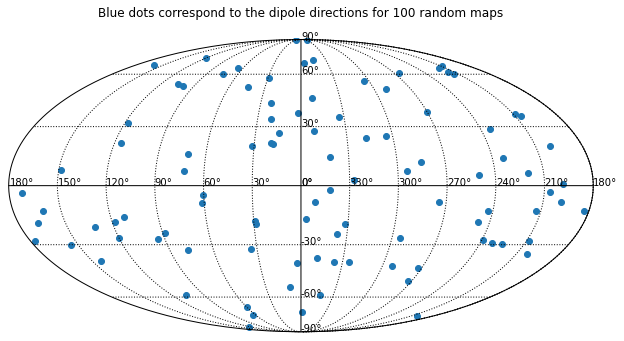

In [23]:
hp.mollview(title='Blue dots correspond to the dipole directions for %s random maps\n'%len(map_random_cls))
hp.graticule()

x_lon = [0,30,60,90,120,150,179,180,210,240,270,300,330]
y_lon = [0,0,0,0,0,0,0,0,0,0,0,0,0]
lab_lon = ['0°','30°','60°','90°','120°','150°','180°','180°','210°','240°','270°','300°','330°']
for i in range(len(x_lon)):
    hp.projtext(x_lon[i],y_lon[i], str(lab_lon[i]), lonlat=True)

x_lat = [0,0,0,0,0,0,0]
y_lat = [0,30,60,90,-90,-60,-30]
lab_lat = ['0°','30°','60°','90°','-90°','-60°','-30°']
for i in range(len(x_lat)):
    hp.projtext(x_lat[i],y_lat[i], str(lab_lat[i]), lonlat=True)

latitudes_random_cls = np.array(angles_random_cls).T[0]
longitudes_random_cls = np.array(angles_random_cls).T[1]
hp.projscatter(longitudes_random_cls,latitudes_random_cls,lonlat=True)

#lab = ['map1', 'map2', 'map3', 'map4', 'map5', 'map6','map7','map8','map9','map10']
#for map_ in range(nb_maps):
#    hp.projtext(latitudes[map_],longitudes[map_], str(lab[map_]), lonlat=True)
plt.show()

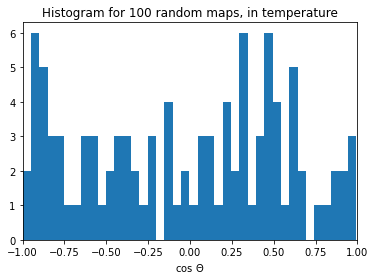

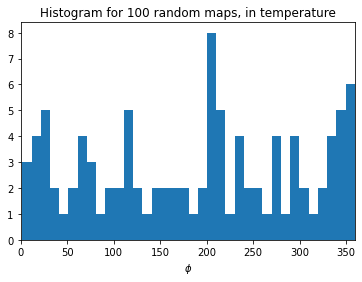

In [75]:
plt.hist(np.cos(np.radians(latitudes_random_cls+90)), density=False, bins=40)
plt.xlabel('cos $\Theta$')
plt.xlim([-1,1])
plt.title('Histogram for %s random maps, in temperature'%len(map_random_cls))
plt.show()

plt.hist(longitudes_random_cls, density=False, bins=36)
plt.xlabel('$\phi$')
plt.xlim([0,360])
plt.title('Histogram for %s random maps, in temperature'%len(map_random_cls))
plt.show()

Maps with random dipole directions:

In [19]:
maps = 1500 #3000
random_vectors = np.random.normal(loc=0.0, scale=1.0, size=3*maps)
random_vectors = np.reshape(random_vectors, (int(len(random_vectors)/3),3))
for i in range(len(random_vectors)):
    random_vectors[i] /= np.linalg.norm(random_vectors[i])

angles_random_vectors = []
for i in range(len(random_vectors)):
    angles_random_vectors.append(retrieve_angles(random_vectors[i]))

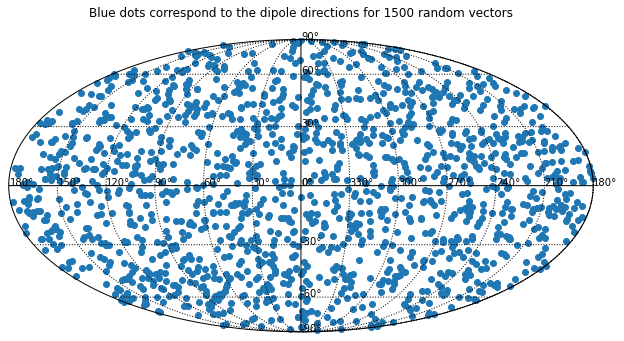

In [8]:
hp.mollview(title='Blue dots correspond to the dipole directions for %s random vectors\n'%len(random_vectors))
hp.graticule()

x_lon = [0,30,60,90,120,150,179,180,210,240,270,300,330]
y_lon = [0,0,0,0,0,0,0,0,0,0,0,0,0]
lab_lon = ['0°','30°','60°','90°','120°','150°','180°','180°','210°','240°','270°','300°','330°']
for i in range(len(x_lon)):
    hp.projtext(x_lon[i],y_lon[i], str(lab_lon[i]), lonlat=True)

x_lat = [0,0,0,0,0,0,0]
y_lat = [0,30,60,90,-90,-60,-30]
lab_lat = ['0°','30°','60°','90°','-90°','-60°','-30°']
for i in range(len(x_lat)):
    hp.projtext(x_lat[i],y_lat[i], str(lab_lat[i]), lonlat=True)

latitudes_random_vectors = np.array(angles_random_vectors).T[0]
longitudes_random_vectors = np.array(angles_random_vectors).T[1]
hp.projscatter(longitudes_random_vectors,latitudes_random_vectors,lonlat=True)

#lab = ['map1', 'map2', 'map3', 'map4', 'map5', 'map6','map7','map8','map9','map10']
#for map_ in range(nb_maps):
#    hp.projtext(latitudes[map_],longitudes[map_], str(lab[map_]), lonlat=True)
plt.show()

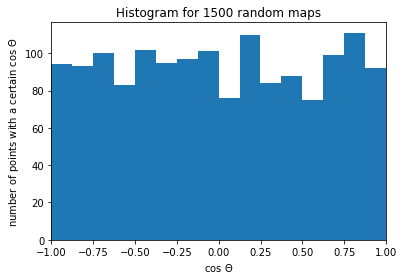

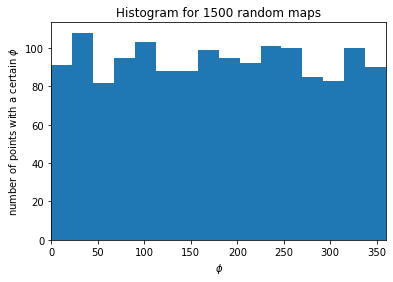

In [20]:
plt.hist(np.cos(np.radians(latitudes_random_vectors+90)), density=False, bins=16) #bins=40)
plt.xlabel('cos $\Theta$')
plt.ylabel('number of points with a certain cos $\Theta$')
plt.xlim([-1,1])
plt.title('Histogram for %s random maps'%len(random_vectors))
plt.show()

plt.hist(longitudes_random_vectors, density=False, bins=16) #bins=36)
plt.xlabel('$\phi$')
plt.ylabel('number of points with a certain $\phi$')
plt.xlim([0,360])
plt.title('Histogram for %s random maps'%len(random_vectors))
plt.show()